---
# Exercises for Modern Experimental Physics III
## Exercise sheet 2: Detector simulation
---

This exercise sheet targets the general workflow understanding of detector simulation studies. Firstly, [Exercise 0](#Exercise0) provides an overview of the here used methods to access the `geant4_simulation` package which provides a user-friendly and quick frontend to the underlying `Geant4` framework. For any in-depth questions about the presented methods, do not be afraid of checking the `geant4_simulation` code. Secondly, [Exercise 1](#Exercise1) discusses in a lightweight fashion the interaction of photons and electrons with matter. Subsequently, [Exercise 2](#Exercise2) studies in-depth the generation and properties of electromagnetic showers. [Exercise 3](#Exercise3) performs a simplified calibration to connect a measured detector readout to the observed deposited energy of photons. 

---
# Exercise 0: Introduction to *python* Workflow with Geant4 <a id="Exercise0"></a>
---

The key aspects of the workflow with Geant4 in pyhton for the following exercise are implemented in the `geant4_simulation` package and made accessible to the user via the `ApplicationManager` class. First, to start the simulating events, the package needs to be loaded and the steering class `ApplicationManager` has to be constructed. For a better understanding of the following procedure, it may be advisable to study the code in `geant4_simulation/__init__.py`.

In [1]:
import geant4_simulation as g4sim
# Create an instance of the ApplicationManager class.
g4 = g4sim.ApplicationManager()


**************************************************************
 Geant4 version Name: geant4-10-06-patch-02    (29-May-2020)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************

Visualization Manager instantiating with verbosity "warnings (3)"...


There are three main ingredients to a simulation of the passage of particles through matter using Geant4:
1. The *description of the target*
2. The *underlying interaction*
3. The *initial state*

## 1. Target
The geometrical structure and the compounds of the simulated detector used in the exercises are already provided in the `geant4_simulation` package. Thus, for the exercises it suffices to just load the corresponding geometry with the `set_geometry()` module from the `ApplicationManager` class. All geometries, including their properties and arguments can be looked up in `geant4_simulation/geometry/`.

A simple lead geometry can be loaded from the geometry `pbbox`. As a default, the lead volume is 20 cm long and 10 cm in height and width. You can specify the dimensions with additional arguments of the `pbbox` geometry (dimensions in units of cm) where the second given parameter corresponds to the width and height of the lead volume:

In [2]:
# Set the geometry to example_geometry.
g4.set_geometry('pbbox(2,2)')

The `pbbox` geometry creates a volume of lead as a default, but you can also switch the material to iron:
```python
g4.change_material("Fe")
```
This method will change the material from the previous material to the material given as an argument. Currently, only iron and lead are supported as materials.

## 2. Underlying Interaction

The second main ingredient of a simulation with Geant4 is the physics list. It specifies all particles and interactions considered in the simulation. It is mandatory for all simulations. While the Geant4 collaboration provides a vast amount of different lists which are useful for various applications, most experiments decide to define a specialised list for their own needs (like target properties, particle energies, physics needs,...). 

You do not need to modify any of the physics lists. For the first exercise, we will use a physics list that only defines electromagnetic interactions of the involved particles. Additional lists can be found in `geant4_simulation/physicsList/src/`.

In [3]:
# Set the physics list used during the simulation.
g4.set_physics_list('EMPhysics')

After the used detector geometry and physics lists are defined, the Geant4 kernel can be initialized. Note that the geometry may be changed after the initialization of the kernel whereas the physics lists can only be changed before calling the `initialize()` method. To enable the changes in the geometry the `initialize()` method needs to be invoked.

In [4]:
# Initialize the Geant4 kernel.
g4.initialize()

<<< Geant4 Physics List simulation engine: EMPhysics



## 3. Initial State

Lastly, the third ingredient of the simulation is the specification of the incoming particles that hit the detector during the simulation. Throughout the exercises, we will use varying single incident particles with specified incoming energies. The type of the primary particle can be set using the MC Particle Numbering scheme defined by the Particle Data Group ([PDG](https://pdg.lbl.gov/2024/reviews/rpp2024-rev-monte-carlo-numbering.pdf)) of the requested particle.

To define the incoming particle use the `set_particle(Particle)` method of the steering class. Here, `Particle` can be any Geant4 accepted value - for this exercise the integer PDG code of a particle suffices. The initial energy of the particle can be set by the `set_energy(Value)` method where `Value` defines the energy in GeV.

In [5]:
# Set the primary particle used in the simulation.
g4.set_particle(22) # 22 = photon
g4.set_energy(0.001)  # 1 MeV initial energy.

After defining all necessary input parameters of the simulation, the simulation can be started using the `start_run()` method. You can specify, the number of simulated events you want to produce and whether the simulated events should be visualized using the `numberOfEvents` and `visualize` keyword arguments, respectively. The default number of simulated events is 1 and by default the visualization of the event is disabled. The first invocation of the `start_run()` method will produce a large list of all defined physical processes in the physics list and the parameters of the corresponding processes.

In [6]:
g4.start_run()


phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 63 bins 
      ===== EM models for the G4Regi

---
# Exercise 1: Interaction of photons with matter <a id="Exercise1"></a>
---

In the following exercise, we will determine the rate of different photon interactions with matter as a function of the photon energy by taking into account the bremsstrahlung of the electrons. During the exercise we are going to simulate the interaction of photons with energies up to 30 MeV and a small lead block and classify the occuring prcoesses. We will use this exercise to briefly discuss how a simulation study in Geant4 can be set up using the `geant4_simulation` interface.

As a first, purely qualitative step, study visually the interaction of photons with a $(2\times 2\times 2)\,$cm lead block. For this pupose, start runs at energies in the $\mathcal{0}(1\,\textrm{MeV}), \mathcal{0}(10\,\textrm{MeV}), \mathcal{0}(100\,\textrm{MeV}), \mathcal{0}(1\,\textrm{GeV}), \mathcal{0}(10\,\textrm{GeV})$ spectrum and try to identify all the different interactions.

**Hint:** To get a graphical representation of the simulation you have to explicitly set the corresponding option `visualize=True` when calling the `start_run()` method. To determine the type of process, the charges of the participating particles can be analysed. The colours of the tracks in the event display tell you the charge of the corresponding particle
* photon: green
* electron: blue
* positron: magenta

<div class="alert alert-info">
<strong>Question 1.1:</strong> 
What processes can you observe? Do the rates of the occurring processes change at different energies? 
</div>

<div class="alert alert-success">
<strong>Answer 1.1:</strong> 
    
*Your answer...*
</div>

/tracking/storeTrajectory 2
Output file: g4_0000.prim
Destination directory (current dir if NULL): 
Maximal number of files in the destination directory: 1
Note:                                                
  * The maximal number is customizable as:           
       % setenv  G4DAWNFILE_MAX_FILE_NUM  number 
  * The destination directory is customizable as:
       % setenv  G4DAWNFILE_DEST_DIR  dir_name/  
     ** Do not forget "/" at the end of the    
        dir_name, e.g. "./tmp/".  

File  g4_0000.prim  is generated.
No viewer is invoked.
/tracking/storeTrajectory 2
Output file: g4_0000.prim
Destination directory (current dir if NULL): 
Maximal number of files in the destination directory: 1
Note:                                                
  * The maximal number is customizable as:           
       % setenv  G4DAWNFILE_MAX_FILE_NUM  number 
  * The destination directory is customizable as:
       % setenv  G4DAWNFILE_DEST_DIR  dir_name/  
     ** Do not forget "/" at the

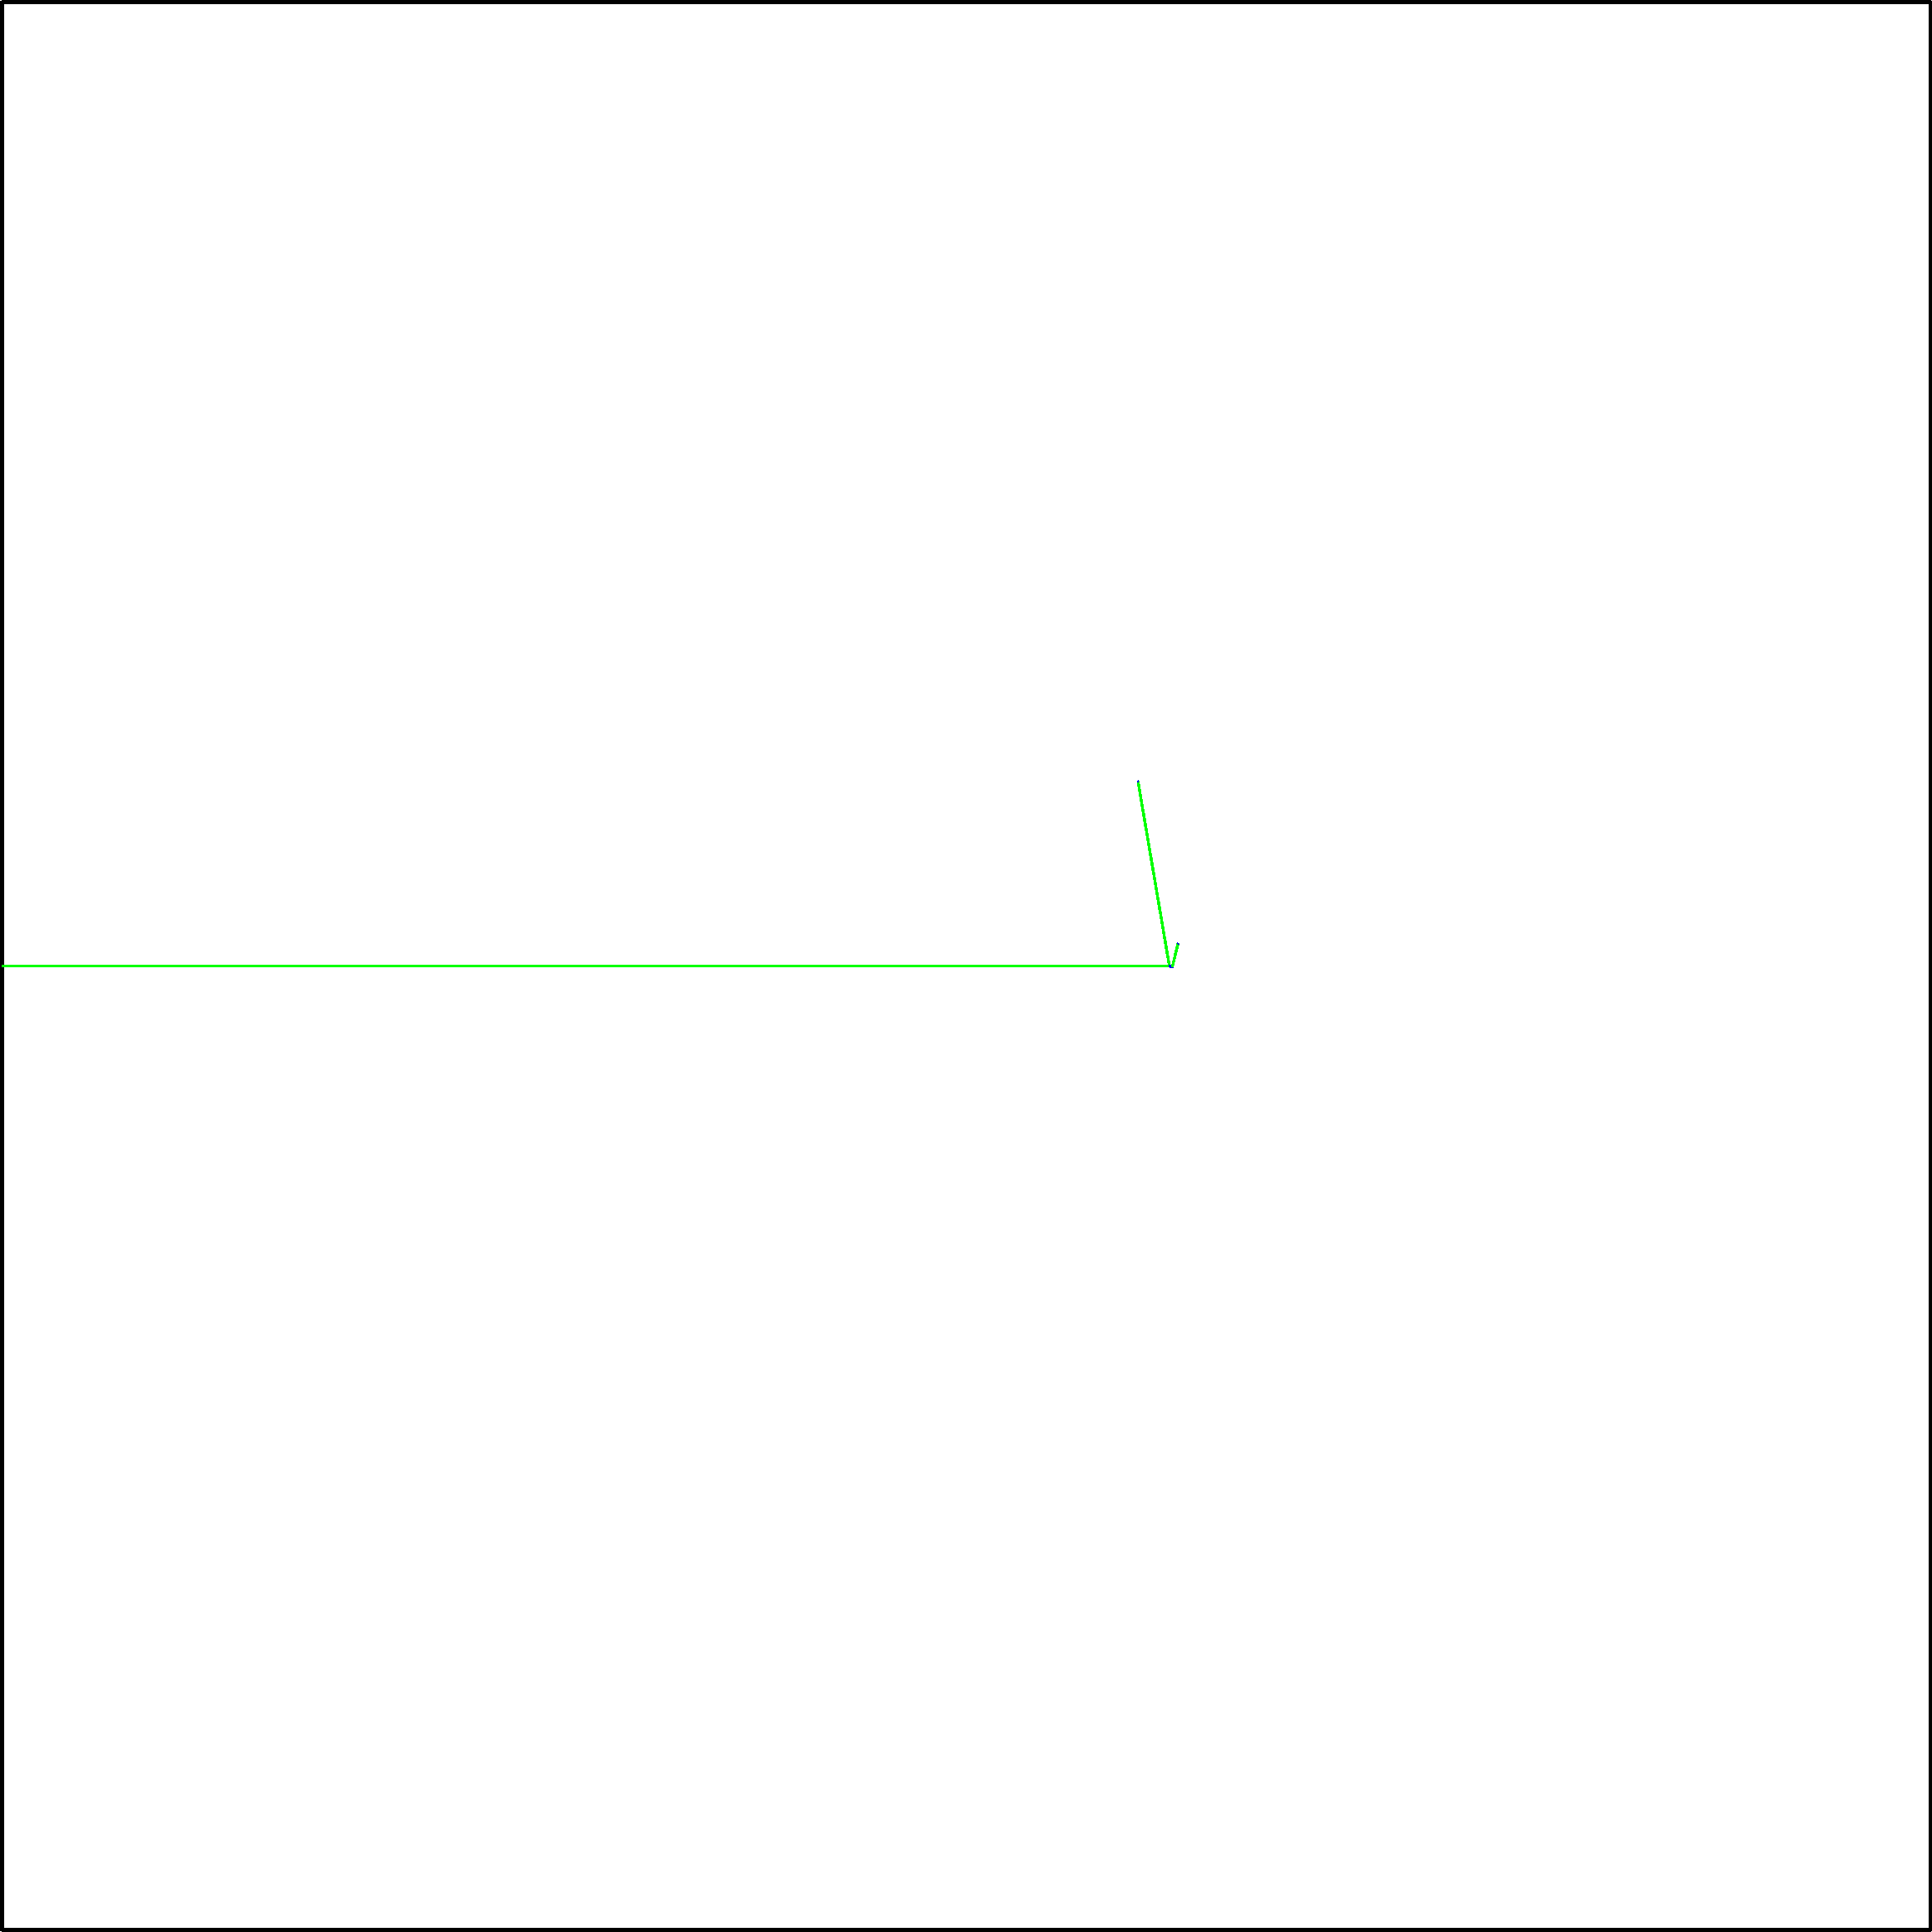

[0.0, -1.0, -1.0, 0.0, -1.0]
{'compt', 'phot'}
Output file: g4_0000.prim
Destination directory (current dir if NULL): 
Maximal number of files in the destination directory: 1
Note:                                                
  * The maximal number is customizable as:           
       % setenv  G4DAWNFILE_MAX_FILE_NUM  number 
  * The destination directory is customizable as:
       % setenv  G4DAWNFILE_DEST_DIR  dir_name/  
     ** Do not forget "/" at the end of the    
        dir_name, e.g. "./tmp/".  

File  g4_0000.prim  is generated.
No viewer is invoked.


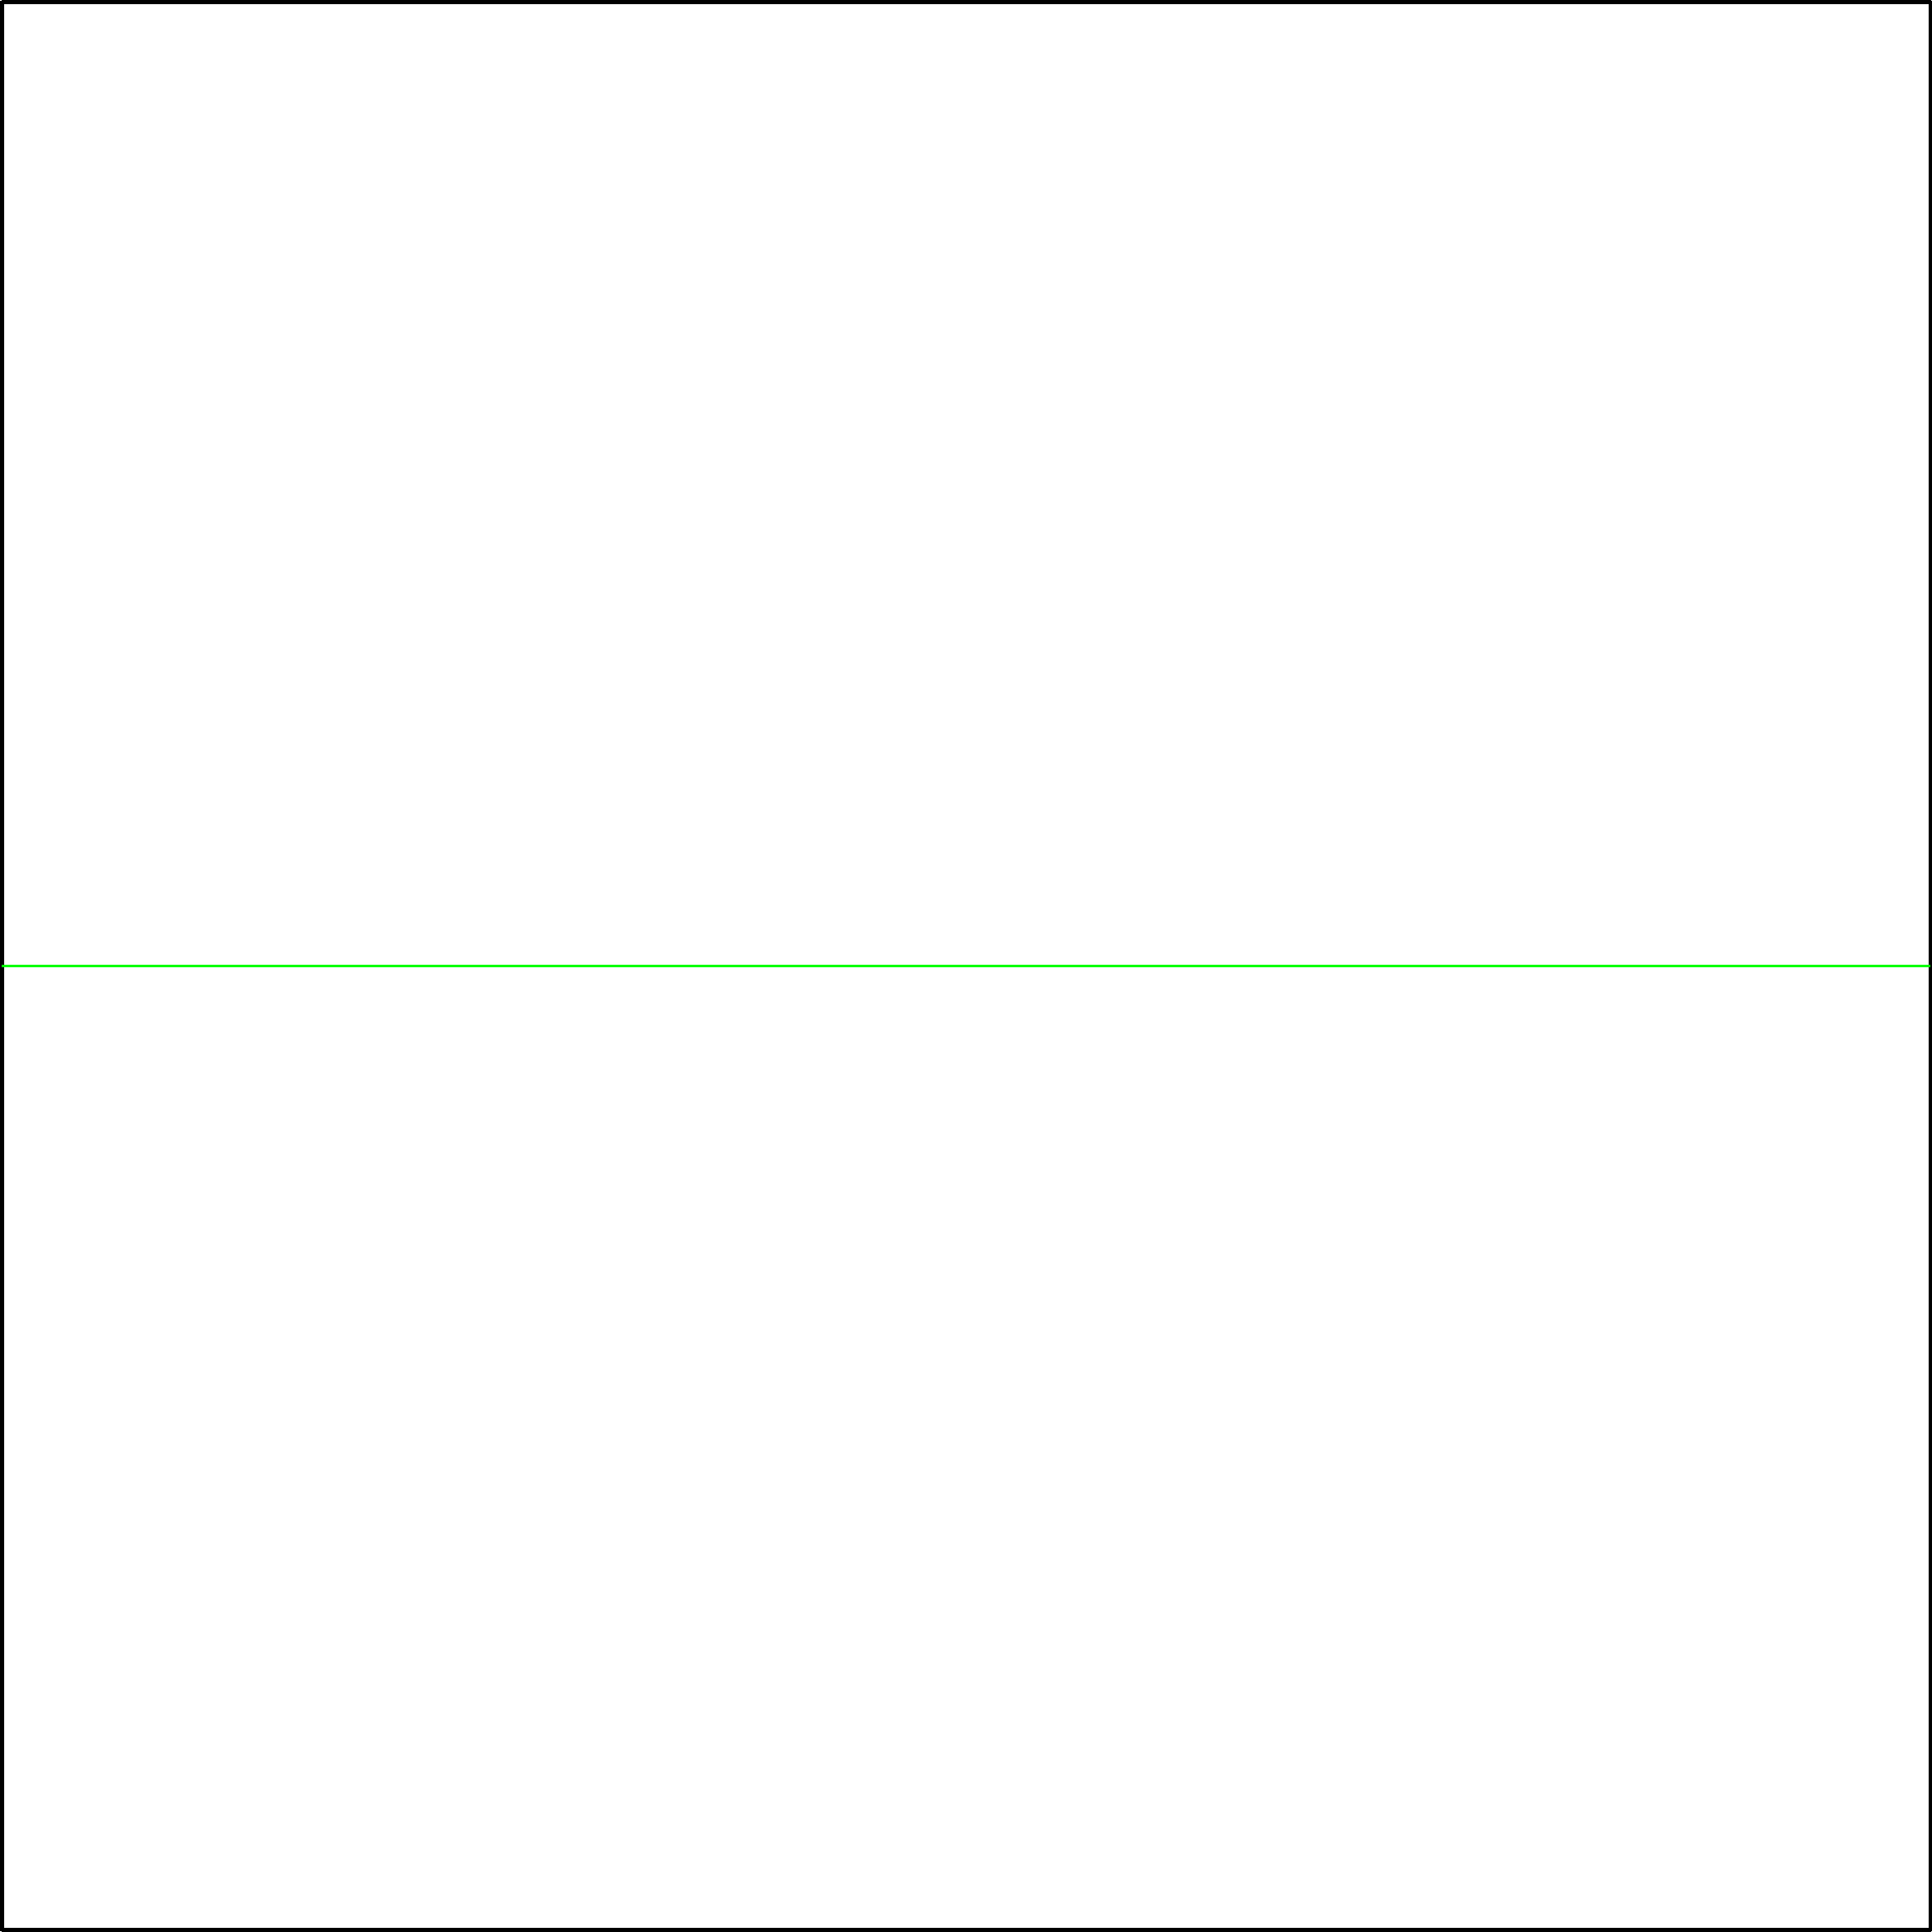

[0.0]
set()
Output file: g4_0000.prim
Destination directory (current dir if NULL): 
Maximal number of files in the destination directory: 1
Note:                                                
  * The maximal number is customizable as:           
       % setenv  G4DAWNFILE_MAX_FILE_NUM  number 
  * The destination directory is customizable as:
       % setenv  G4DAWNFILE_DEST_DIR  dir_name/  
     ** Do not forget "/" at the end of the    
        dir_name, e.g. "./tmp/".  

File  g4_0000.prim  is generated.
No viewer is invoked.


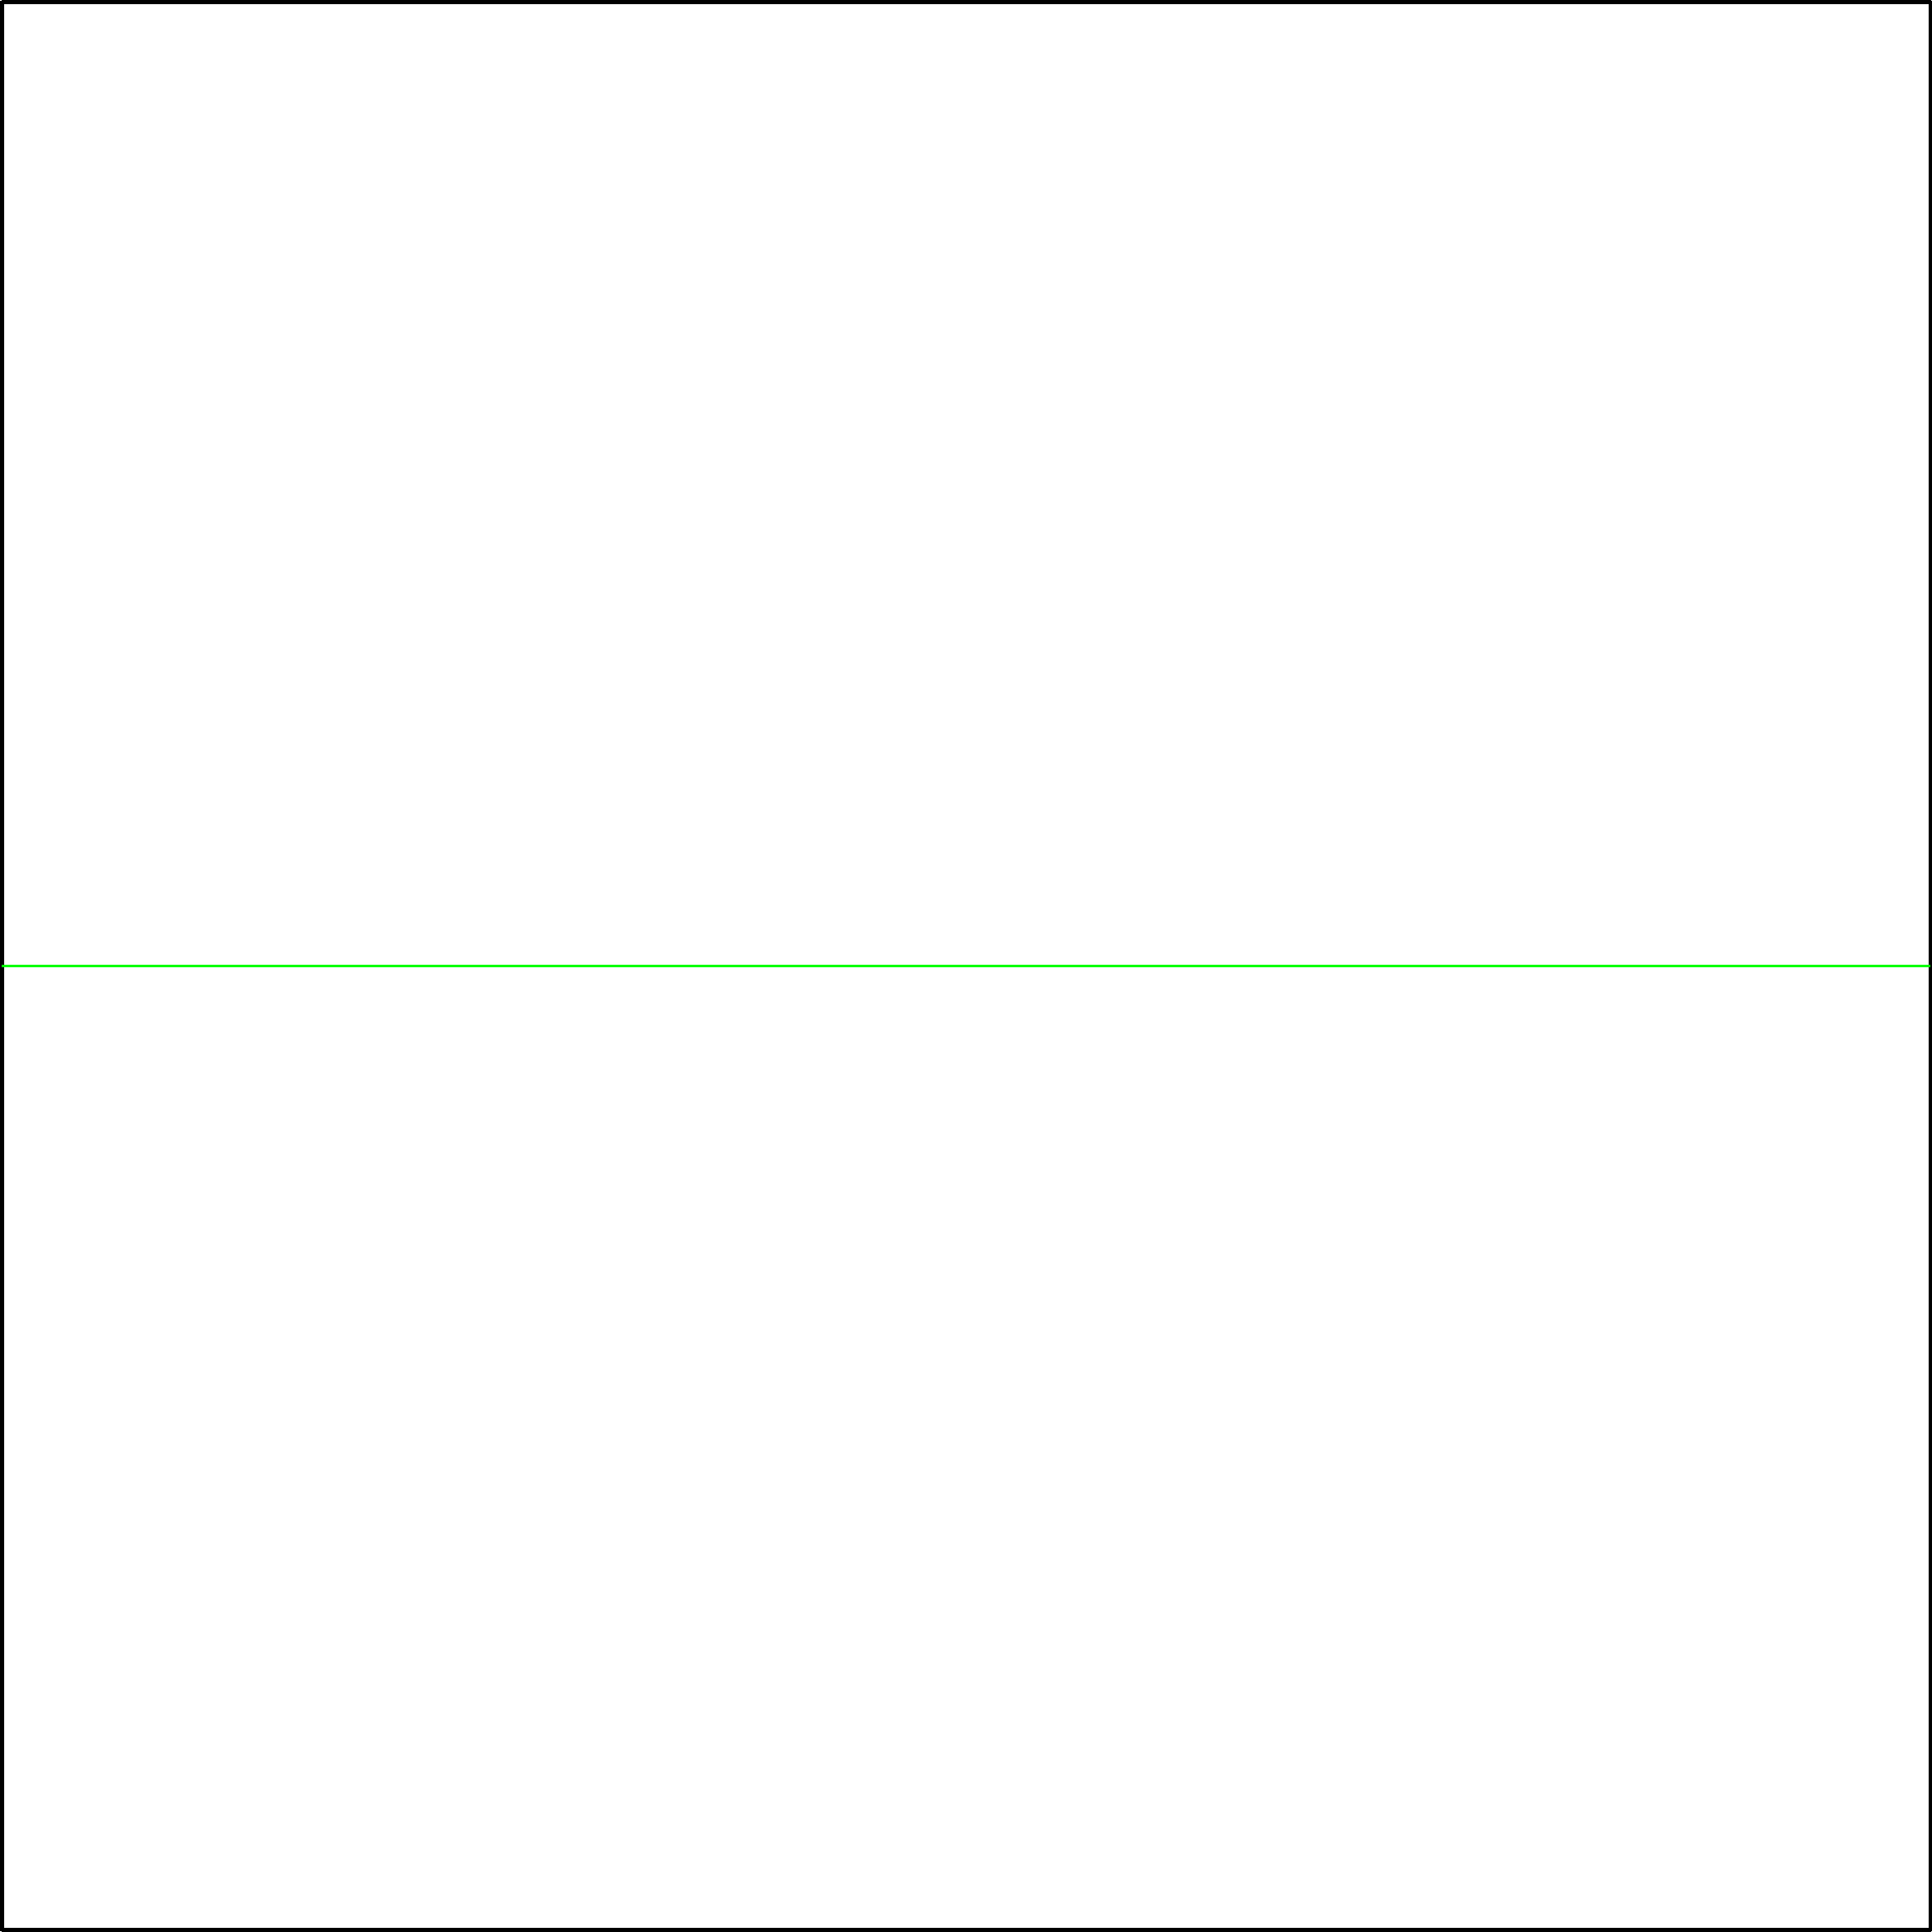

[0.0]
set()
Output file: g4_0000.prim
Destination directory (current dir if NULL): 
Maximal number of files in the destination directory: 1
Note:                                                
  * The maximal number is customizable as:           
       % setenv  G4DAWNFILE_MAX_FILE_NUM  number 
  * The destination directory is customizable as:
       % setenv  G4DAWNFILE_DEST_DIR  dir_name/  
     ** Do not forget "/" at the end of the    
        dir_name, e.g. "./tmp/".  

File  g4_0000.prim  is generated.
No viewer is invoked.


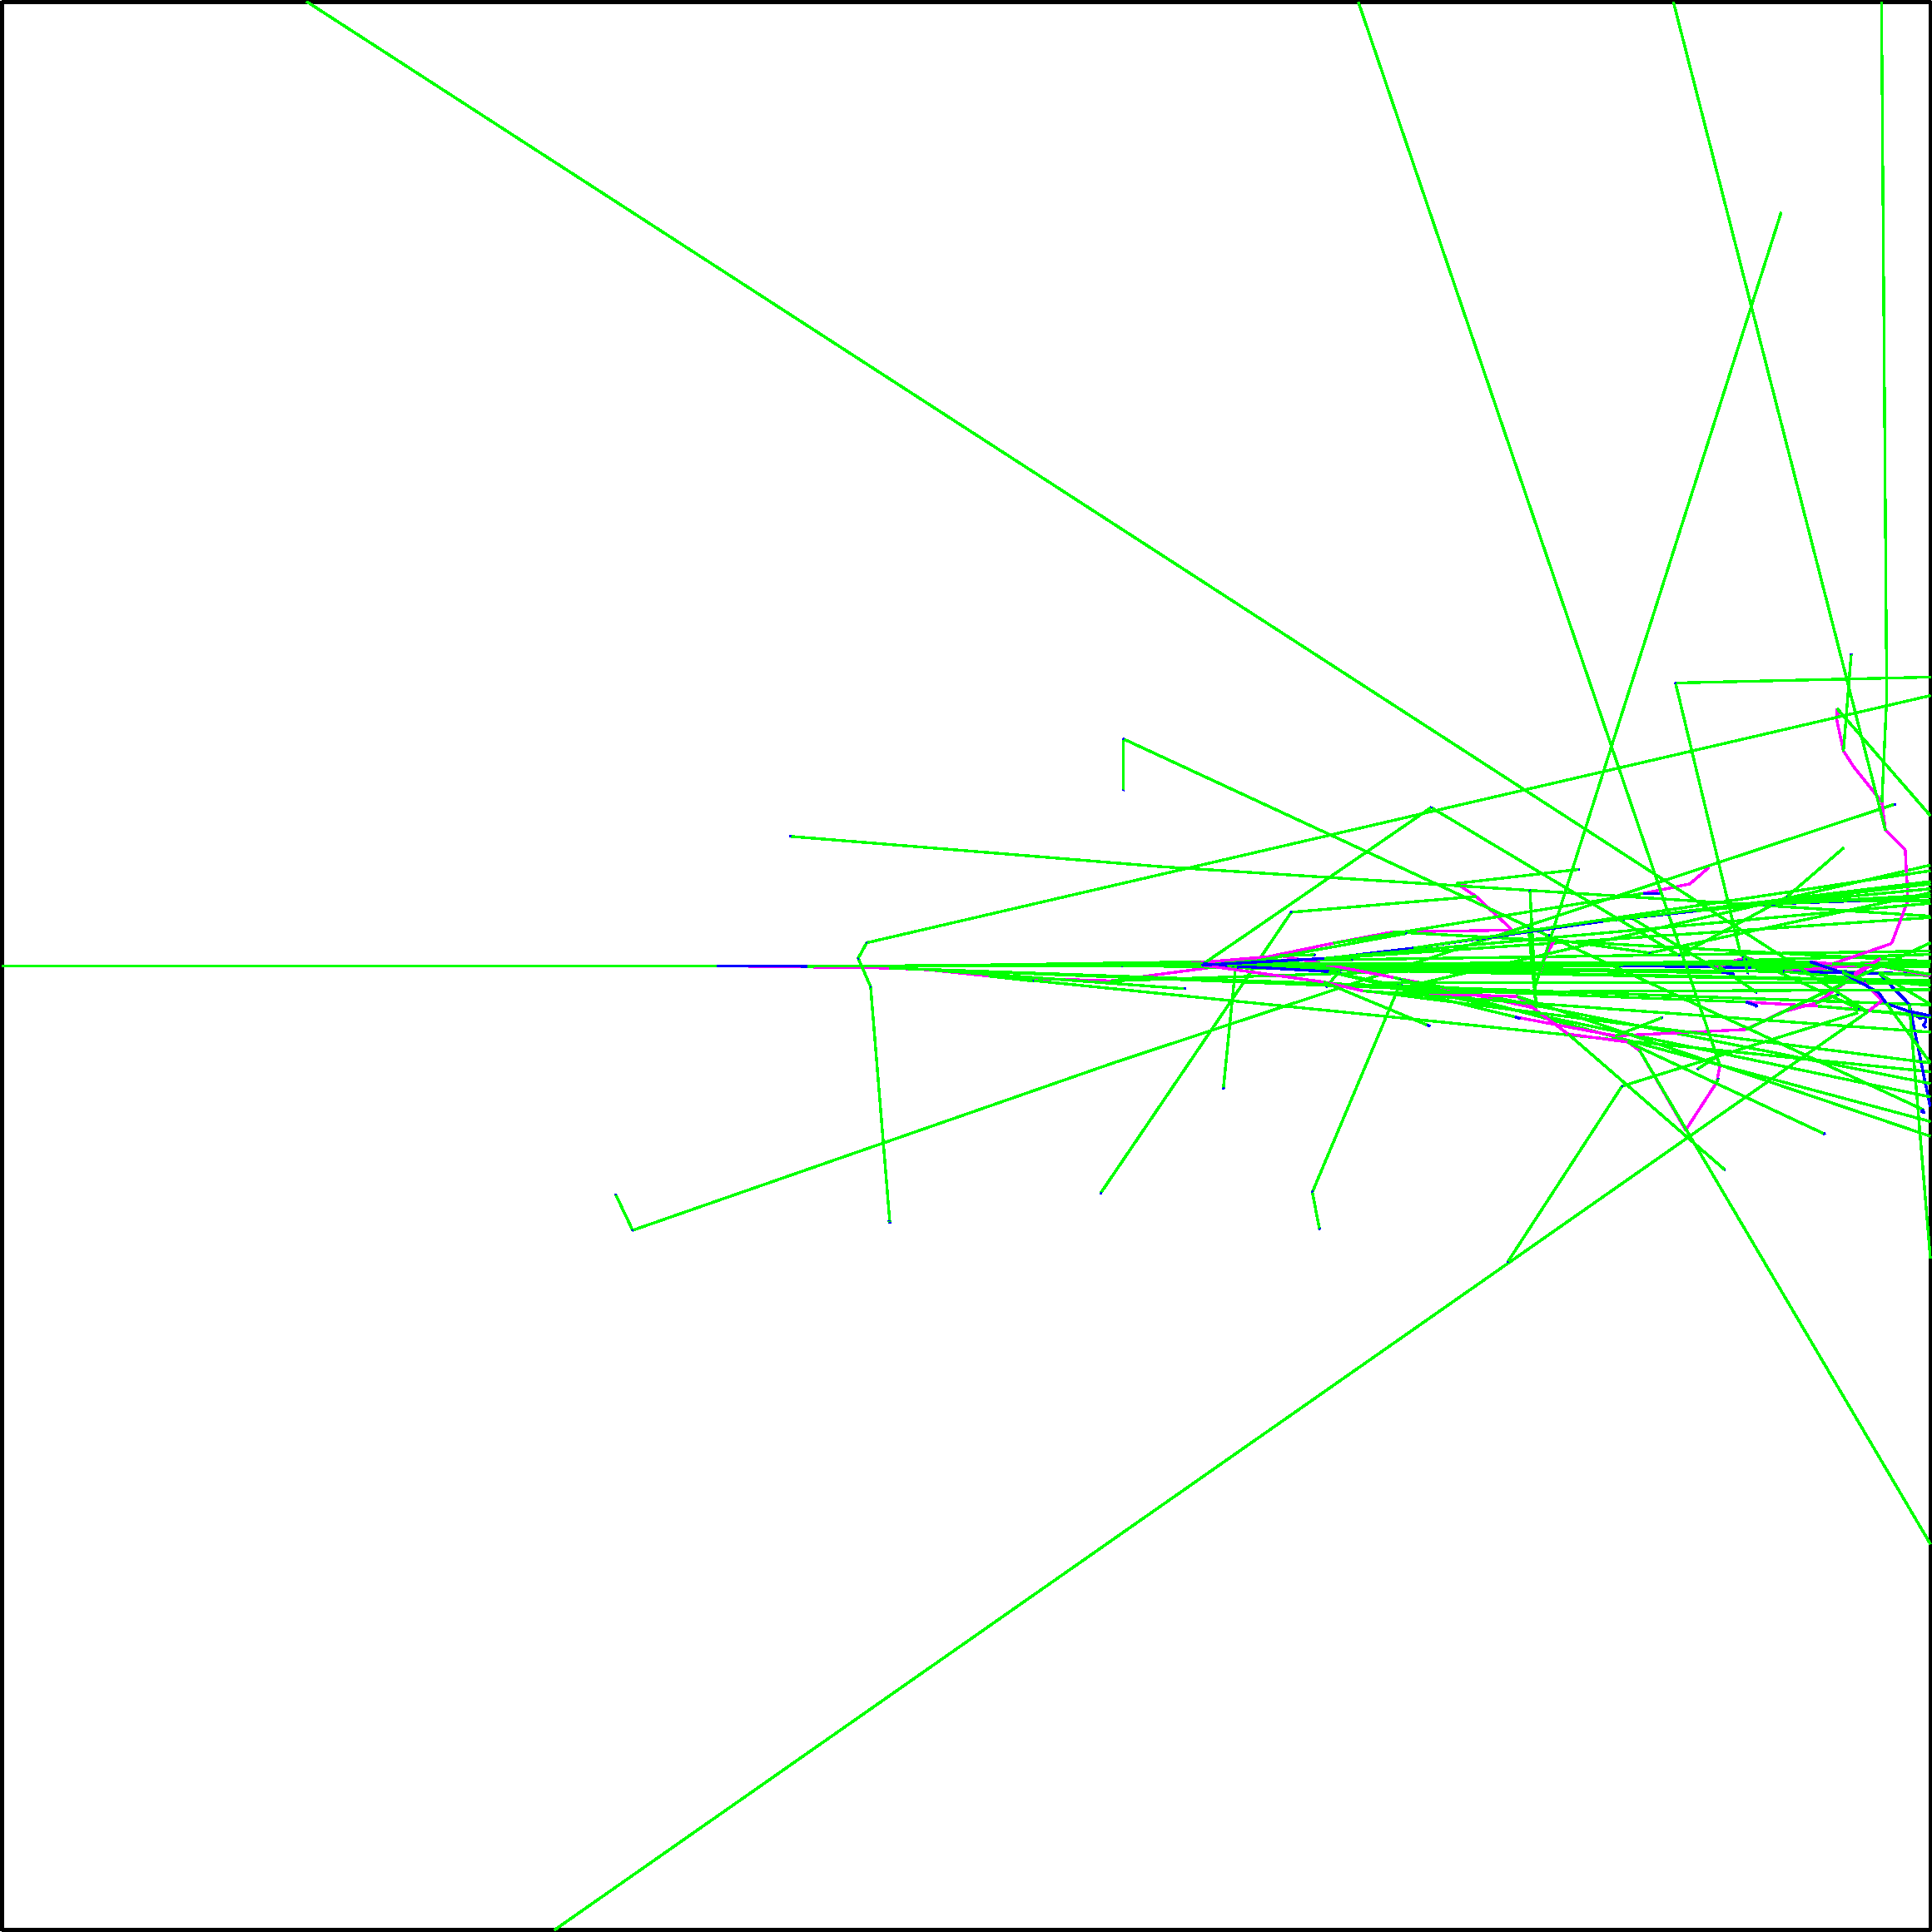

[0.0, 1.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 1.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, 1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, 1.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0]
{'conv'}
Output file: g4_000

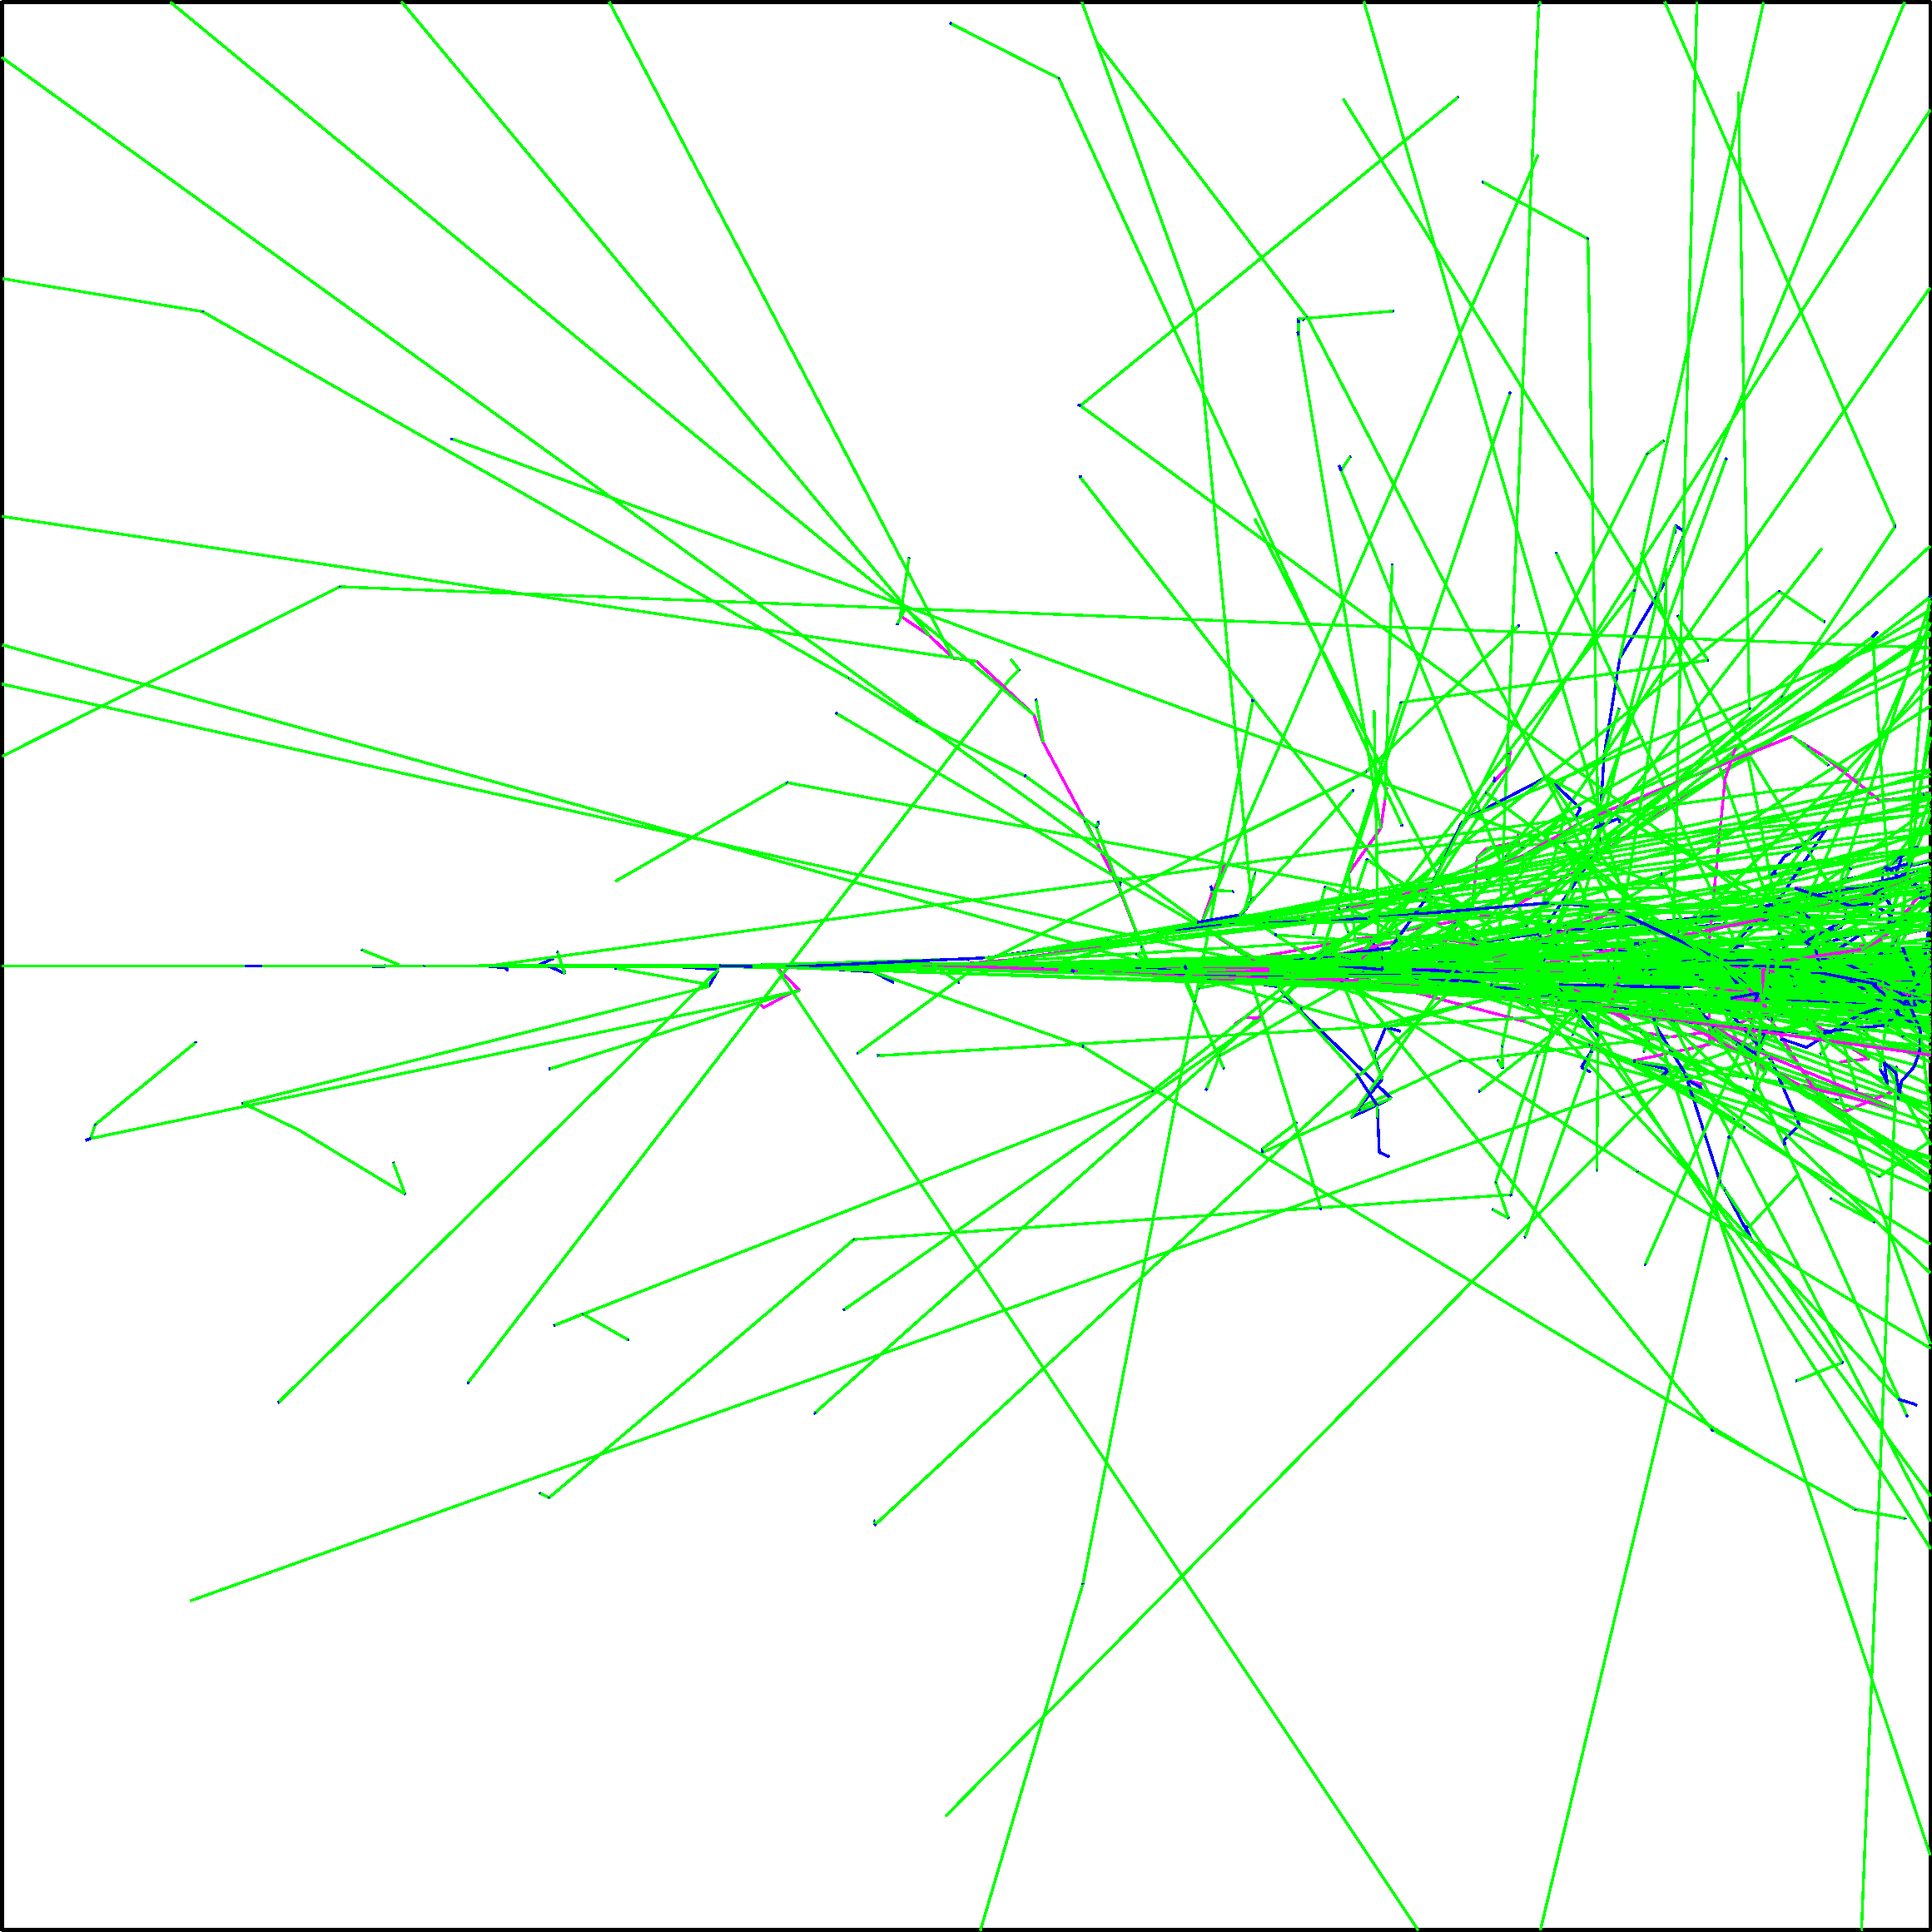

[0.0, 1.0, 0.0, 0.0, -1.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, 1.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0, 0.0, -1.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, 0.0, -1.0, 0.0, 0.0, -1.0, 0.0,

In [7]:
# Set the geometry to example_geometry.
g4.set_geometry('pbbox(2,2)')

# Set the physics list used during the simulation.
g4.set_physics_list('EMPhysics')

# Initialize the Geant4 kernel.
g4.initialize()

# Set the primary particle used in the simulation.
g4.set_particle(22) # 22 = photon

energies = [0.001, 0.01, 0.1, 1, 10]

edep_volumes = []
calo_readouts = []
charges = []
deposits = []
interactions = []

for i in energies: 

    g4.set_energy(i)  # 1 MeV initial energy.

    g4.start_run(numberOfEvents=1, visualize=1)
    
    charges.append(g4.get_charges())
    
    print(g4.get_charges())
    
    interactions.append(g4.get_first_interaction())

    print(g4.get_first_interaction())


Now, we would like to analyse the rate of different elementary processes more quantitatively. For a large number of events, it is not feasible to analyse the event displays by hand. Interactions of the initial photon for a **single event** can be extracted with the `get_first_interaction()` method of the steering class (This still holds true, even if the run is performed with more than one `numberOfEvents`). In this case, the output of `get_first_interaction()` is a set containing the leading processes as strings or in case of no interaction an empty set. In cases where there is an interaction recorded, the output can be "compt" for Compton scattering, "conv" for pair production or "phot" for the photo electric effect. There is the possibility that the initial particle has Compton scattered and then performed another interaction so the output of `get_first_interaction()` will contain more than one value.

For this analysis, write a method that performs the simulations of multiple, singular runs depending on a given energy and number of total events. This method should keep track of all the possible interactions (including none) and return the total number of each after reaching the desired number of simulations. Here, it is sufficient to first check for Compton scattering and only count for it if it occurs. 

Analyse about 50 different energies each in the intervals $[0.1,5]\,\textrm{MeV}$ and $[5,30]\,\textrm{MeV}$ each with around 1000 different events. Keep track of the different processes and plot the relative occurrence over the simulated energy (a plot with a logarithmic $x$-scale could ring a bell).

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def runs(min_energ, max_energ, nr_of_energies, nr_events):
    
    energies = np.zeros(nr_of_energies)
    none = np.zeros(nr_of_energies)
    compt = np.zeros(nr_of_energies)
    conv = np.zeros(nr_of_energies)
    phot = np.zeros(nr_of_energies)
    
    ene = 0
    
    for i in range(nr_of_energies):
        
        rng = np.random.default_rng()
        
        ene_new = rng.uniform(min_energ, max_energ)
        
        #print(ene_new)
        
        while ene_new == ene:
            ene_new = np.random.uniform(min_energ, max_energ)
        
        ene = ene_new
        
        procs = {"energy":ene, "none": 0, "compt": 0, "conv": 0, "phot": 0}
        
        g4.set_energy(ene)
        
        for j in range(nr_events):
            g4.start_run(numberOfEvents=1, visualize=0)
            
            interactions = g4.get_first_interaction()
            
            procs[count_proc(interactions)] += 1
        
        energies[i] = ene
        none[i] = procs.get("none")
        compt[i] = procs.get("compt")
        conv[i] = procs.get("conv")
        phot[i] = procs.get("phot") 
        
        #print(procs)
    
    return energies, none, compt, conv, phot
        
def count_proc(set):
    
    if "compt" in set:
        #procs["comp"] =+ 1
        
        return "compt"
    
    elif "conv" in set:
        #procs["conv"] =+ 1
        
        return "conv"
    
    elif "phot" in set:
        #procs["phot"] =+ 1
        
        return "phot"
    
    else:
        #procs["none"] =+ 1
        
        return "none"

print("One:")
run_1 = runs(0.0001, 0.005, 51, 1001)

print("Two:")
run_2 = runs(0.005, 0.03, 51, 1001)

energies_full_pb = np.concatenate((run_1[0], run_2[0]))
none_full_pb = np.concatenate((run_1[1], run_2[1]))
compt_full_pb = np.concatenate((run_1[2], run_2[2]))
conv_full_pb = np.concatenate((run_1[3], run_2[3]))
phot_full_pb = np.concatenate((run_1[4], run_2[4]))

#print(energies_full)

One:
Two:


In [9]:
def plot(material, xLimLower, xLimUpper, *args):

    #markers =['<','>','^','v','1','2','3','4']
    
    ## Plot Size ##
    
    fig = plt.figure()
    fig.set_figwidth(12)
    fig.set_figheight(7)

    #plt.yscale('log')
    
    x = args[0]*1000
    xLimLower = xLimLower*1000
    xLimUpper = xLimUpper*1000
    

    if material == 'lead':
        
        plt.plot(x, args[1]/1000, '<', markersize=5, linestyle='None', label="No Interaction (Pb)")
        plt.plot(x, args[2]/1000, '>', markersize=5, linestyle='None', label="Compton Scattering (Pb)")
        plt.plot(x, args[3]/1000, '^', markersize=5, linestyle='None', label="Pair Production (Pb)")
        plt.plot(x, args[4]/1000, 'v', markersize=5, linestyle='None', label="Photoelectric Effect (Pb)")

    elif material == 'iron':
        plt.plot(x, args[1]/1000, '1', markersize=8, linestyle='None', label="No Interaction (Fe)")
        plt.plot(x, args[2]/1000, '2', markersize=8, linestyle='None', label="Compton Scattering (Fe)")
        plt.plot(x, args[3]/1000, '3', markersize=8, linestyle='None', label="Pair Production (Fe)")
        plt.plot(x, args[4]/1000, '4', markersize=8, linestyle='None', label="Photoelectric Effect (Fe)")
    
    elif material == 'both':
        
        plt.plot(x, args[1]/1000, '<', markersize=5, linestyle='None', mec = 'lightblue', mfc = 'lightblue', label="No Interaction (Pb)")
        plt.plot(x, args[2]/1000, '>', markersize=5, linestyle='None', mec = 'bisque', mfc = 'bisque',label="Compton Scattering (Pb)")
        plt.plot(x, args[3]/1000, '^', markersize=5, linestyle='None', mec = 'lightgreen', mfc = 'lightgreen', label="Pair Production (Pb)")
        plt.plot(x, args[4]/1000, 'v', markersize=5, linestyle='None', mec = 'lightcoral', mfc = 'lightcoral', label="Photoelectric Effect (Pb)")

        x = args[5]*1000
        
        plt.plot(x, args[6]/1000, '3', markersize=9, linestyle='None', mec = 'blue', mfc = 'blue', label="No Interaction (Fe)")
        plt.plot(x, args[7]/1000, '4', markersize=9, linestyle='None', mec = 'orange', mfc = 'orange', label="Compton Scattering (Fe)")
        plt.plot(x, args[8]/1000, '2', markersize=9, linestyle='None', mec = 'green', mfc = 'green', label="Pair Production (Fe)")
        plt.plot(x, args[9]/1000, '1', markersize=9, linestyle='None', mec = 'red', mfc = 'red', label="Photoelectric Effect (Fe)")
        
    ##### Pretty Plot #####

    plt.xlim(xLimLower, xLimUpper)
    #plt.xscale('log')
    plt.ylim(-0.025, 1)

    plt.grid(color='lightgray', linestyle='-.', linewidth=0.4)

    ## Fancy Stuff ##

    #Custom Legend Placement
    legend = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                   ncol=2, mode="expand", borderaxespad=0., handleheight = 4.5)

    #print(filename)

    plt.xlabel("Energy in MeV", fontsize=10) # Label X-Achse
    plt.ylabel("Relative occurence of labeled interaction", fontsize=10) # Label X-Achse

    #plt.savefig(r"/home/merlin_temp/Documents/uni/lab/PhyPra3/Optische Tarnkappe/fig/plotsAuswertung/" + filename + ".pdf", bbox_inches='tight')

    plt.show()



<div class="alert alert-info">
<strong>Question 1.2:</strong> 
Does the result match the expectation for the interaction of photons with the material?
</div>

<div class="alert alert-success">
<strong>Answer 1.2:</strong> 

*Your answer...*
</div>

<div class="alert alert-info">
<strong>Question 1.3:</strong> 
How many pair production processes do you see below 1 MeV?
</div>

<div class="alert alert-success">
<strong>Answer 1.3:</strong> 

*Your answer...*
</div>

Lastly, we would like to investigate the influence of the detector material on the interactions occurring.
For this change the material of the detector volume to iron and repeat the simulations done for the lead volume.
Estimate the rates of the occuring processes and compare them to the one obtained for lead.

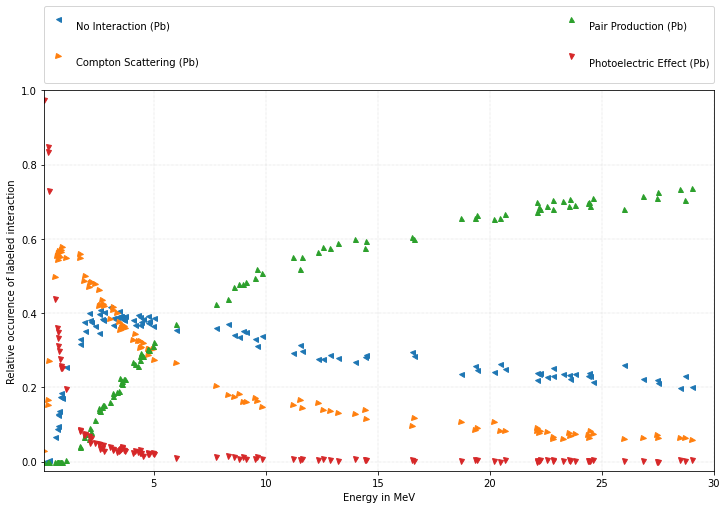

In [10]:
#plot('lead', 0.0001, 0.005, run_1[0], run_1[1], run_1[2], run_1[3], run_1[4])
#plot('lead', 0.005, 0.03, run_2[0], run_2[1], run_2[2], run_2[3], run_2[4])

plot('lead', 0.0001, 0.03, energies_full_pb, none_full_pb, compt_full_pb, conv_full_pb, phot_full_pb)

In [11]:
g4.change_material(material="Iron")

print("One:")
run_1 = runs(0.0001, 0.005, 51, 1001)

print("Two:")
run_2 = runs(0.005, 0.03, 51, 1001)

energies_full_fe = np.concatenate((run_1[0], run_2[0]))
none_full_fe = np.concatenate((run_1[1], run_2[1]))
compt_full_fe = np.concatenate((run_1[2], run_2[2]))
conv_full_fe = np.concatenate((run_1[3], run_2[3]))
phot_full_fe = np.concatenate((run_1[4], run_2[4]))

Target material has been set to iron...
One:

phot:  for gamma SubType=12 BuildTable=0
      LambdaPrime table from 200 keV to 100 TeV in 61 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
 LivermorePhElectric : Emin=    0 eV  Emax=  100 TeV  SauterGavrila Fluo

compt:  for gamma SubType=13 BuildTable=1
      Lambda table from 100 eV  to 1 MeV, 7 bins/decade, spline: 1
      LambdaPrime table from 1 MeV to 100 TeV in 56 bins 
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
       Klein-Nishina : Emin=    0 eV  Emax=  100 TeV

conv:  for gamma SubType=14 BuildTable=1
      Lambda table from 1.022 MeV to 100 TeV, 18 bins/decade, spline: 1
      ===== EM models for the G4Region  DefaultRegionForTheWorld ======
     BetheHeitlerLPM : Emin=    0 eV  Emax=  100 TeV  ModifiedTsai

Rayl:  for gamma SubType=11 BuildTable=1
      Lambda table from 100 eV  to 100 keV, 7 bins/decade, spline: 0
      LambdaPrime table from 100 keV to 100 TeV in 

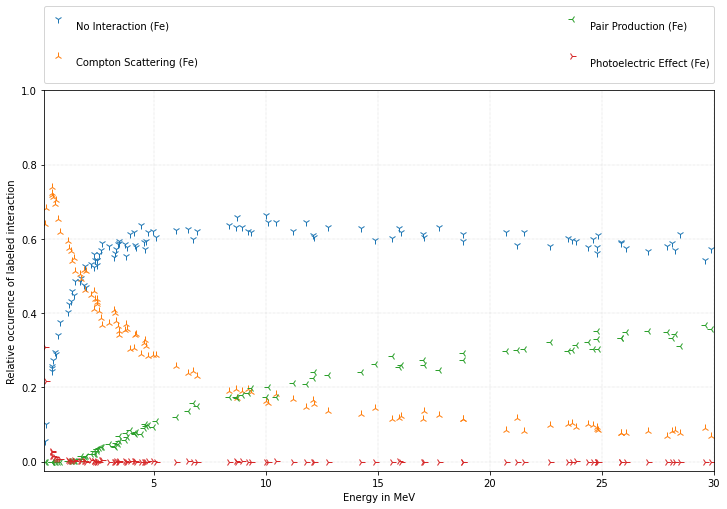

In [12]:
#plot('iron', 0.0001, 0.005, run_1[0], run_1[1], run_1[2], run_1[3], run_1[4])
#plot('iron', 0.005, 0.03, run_2[0], run_2[1], run_2[2], run_2[3], run_2[4])

plot('iron', 0.0001, 0.03, energies_full_fe, none_full_fe, compt_full_fe, conv_full_fe, phot_full_fe)

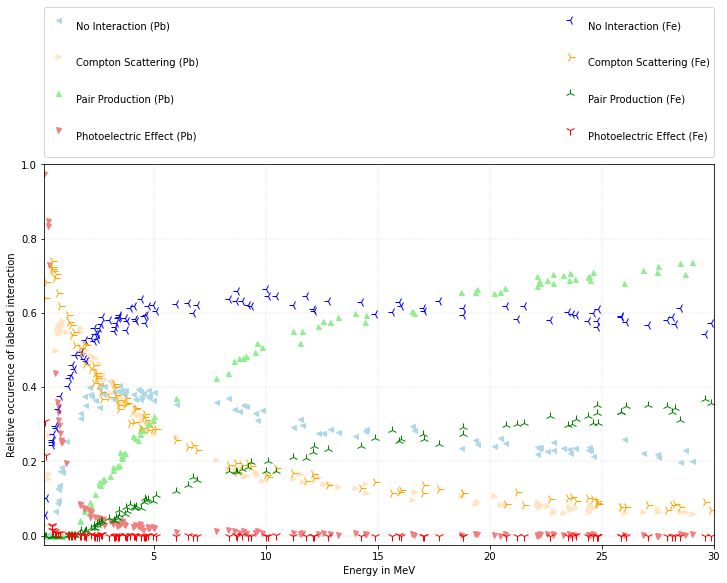

In [13]:
plot('both', 0.0001, 0.03, energies_full_pb, none_full_pb, compt_full_pb, conv_full_pb, phot_full_pb, energies_full_fe, none_full_fe, compt_full_fe, conv_full_fe, phot_full_fe)

<div class="alert alert-info">
<strong>Question 1.4:</strong> 
How do the results change? Motivate your answer with physical arguments.
</div>

<div class="alert alert-success">
<strong>Answer 1.4:</strong> 

*Your answer...*
</div>

---
# Exercise 2: Electromagnetic showers <a id="Exercise2"></a>
---

Within this exercise, we would like to investigate some properties of electromagnetic showers in dense materials. For this, we will start by determining the radiation length of the detector material from the interactions of photons with the material. The second part of the exercise will then focus on the energy profiles of electromagnetic showers and a comparison of photon and electron-induced showers is performed.

To determine the radiation length of lead $X_0^{\mathrm{Pb}}$, simulate 5'000 photons with an energy 1 GeV interacting with a lead block twice the size in each dimension of the one used in the previous exercise, i.e., $(4\times 4\times 4)\,$cm.
Change the geometry accordingly and do not forget to reinitialize the Geant4 kernel with the `initialize()` method.
Create and plot a histogram of the $x$ positions (dimension along the incoming photon) of the first interaction vertex.
To determine the position of the first vertex use the member function `get_x_of_first_vertex()` of the `ApplicationManager`. It returns the $x$ coordinate of the first vertex in cm. (Same usage as `get_first_interaction()`)

**Calculation of $X_0^{\mathrm{Pb}}$ Hint a)** : Use a good approximation to read the value directly from the histogram $x$-axis. <br>
**Calculation of $X_0^{\mathrm{Pb}}$ Hint b)** : Fit the histogram to the expected distribution of $x$ and extract the value as a fitparameter. (Useful modules via `kafe2`: `XYContainer`, `Fit`, `Plot`, `HistContainer`, `kafe2.fit.histogram.HistCostFunction_NegLogLikelihood`

<div class="alert alert-info">
<strong>Question 2.1:</strong> 
What distribution do you expect? Why? Determine the radiation length $X_{0}$ of the detector material. $X_{0}$ corresponds to the depth after which about 54 % of the photons have created an electron-positron pair. 
</div>

<div class="alert alert-success">
<strong>Answer 2.1:</strong>

*Your answer...*
</div>

<div class="alert alert-info">
<strong>Question 2.2:</strong> 
How is this number motivated?
</div>

<div class="alert alert-success">
<strong>Answer 2.2:</strong> <br>

*Your answer...*
</div>

In [14]:
# Set the geometry to example_geometry.
g4.set_geometry('pbbox(4,4)')

# Set the physics list used during the simulation.
g4.set_physics_list('EMPhysics')

# Initialize the Geant4 kernel.
g4.initialize()

# Set the primary particle and particle amount used in the simulation.
g4.set_particle(22) # 22 = photon
g4.set_numberOfParticles(1)

g4.set_energy(1)  # 1 GeV initial energy.

first_vertices=[]

for i in range(5000):

    g4.start_run(numberOfEvents=1, visualize=0)

    first_vertices.append(g4.get_x_of_first_vertex())


/tracking/storeTrajectory 2
Output file: g4_0000.prim
Destination directory (current dir if NULL): 
Maximal number of files in the destination directory: 1
Note:                                                
  * The maximal number is customizable as:           
       % setenv  G4DAWNFILE_MAX_FILE_NUM  number 
  * The destination directory is customizable as:
       % setenv  G4DAWNFILE_DEST_DIR  dir_name/  
     ** Do not forget "/" at the end of the    
        dir_name, e.g. "./tmp/".  

File  g4_0000.prim  is generated.
No viewer is invoked.


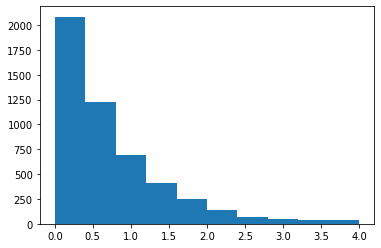

In [15]:
plt.hist(first_vertices)
plt.show()

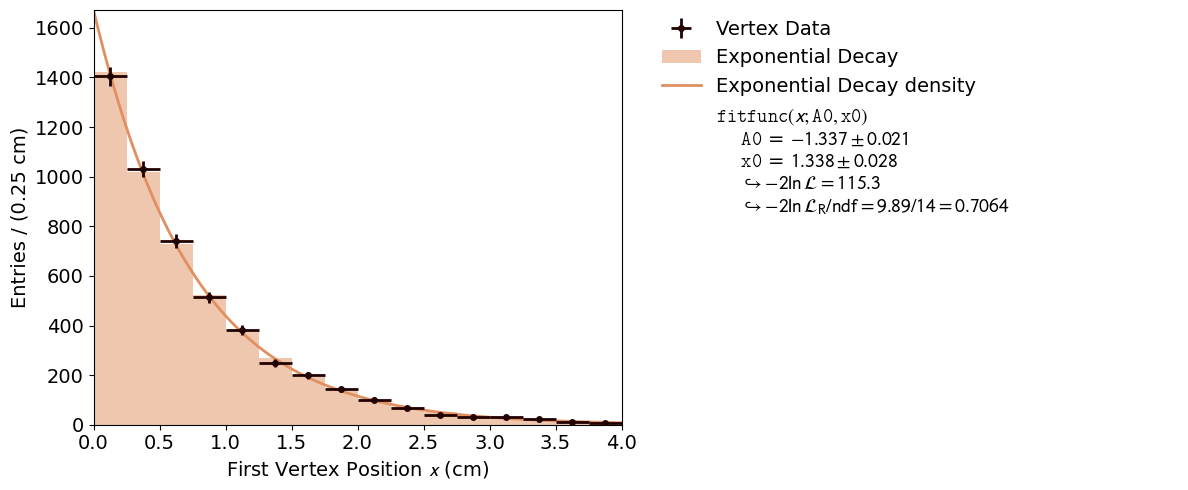

In [16]:
# Use of kafe2 for option b)
from kafe2 import XYContainer, Fit, Plot, HistContainer
from kafe2.fit.histogram import HistCostFunction_NegLogLikelihood


# define fit function
def fitfunc(x, A0=-1., x0=1.):
    return x0 * np.exp(A0*x)

# prepare fit
bin_edges = [0.0, 0.25, 0.5, 0.75, 1., 1.25, 1.5, 1.75, 2., 2.25, 2.5, 2.75, 3., 3.25, 3.5, 3.75, 4.]
nbins = len(bin_edges)-1
bin_range = (bin_edges[0], bin_edges[-1])
hdat = HistContainer(nbins, bin_range, bin_edges=bin_edges, fill_data=first_vertices)

hdat.label = "Vertex Data"
hdat.axis_labels= ['First Vertex Position $x$ (cm)', f'Entries / ({np.mean(np.diff(bin_edges)):.2f} cm)']

hfit = Fit(
    hdat, 
    fitfunc, 
    cost_function=HistCostFunction_NegLogLikelihood(data_point_distribution='poisson')
)

# add cosmetic options
# do not get hung up on this! Skip this, if you do not want to get (non existent) extra points for beauty
#hfit.assign_parameter_latex_names(Syntax: <parameter variable defined as in `fitfunf`>=<latex expression>) # input should be keywardarguments for all function arguments
#hfit.assign_model_function_latex_expression(<latex expression of formula>) # escape \ by \\ and expressions in {} need to be escaped as well, e.g. 1/2=\\frac{{1}}{{2}} or e^foo=e^{{foo}}
hfit.model_label = "Exponential Decay"

# execute fit
hfit.do_fit()

# show fit
plot = Plot(hfit)
foo = plot.plot()
plt.show()

In the second part of the exercise, we are going to analyse the process of the shower evolution for electrons with energies of up to several GeV.
First, we will have a look at the starting point of the showers.
For this, we will use the same detector geometry as in the first part of the exercise. 
Simulating 100 collisions of 1 GeV electrons and analyse the vertex of the first interaction. Compare the resulting distribution to the distribution obtained for photons in the previous part of the exercise.

In [17]:
# Your code # Set the geometry to example_geometry.
g4.set_geometry('pbbox(4,4)')

# Set the physics list used during the simulation.
g4.set_physics_list('EMPhysics')

# Initialize the Geant4 kernel.
g4.initialize()

# Set the primary particle and particle amount used in the simulation.
g4.set_particle(11) # 11 = electron
g4.set_numberOfParticles(1)

g4.set_energy(1)  # 1 GeV initial energy.

first_vertices=[]

for i in range(100):

    g4.start_run(numberOfEvents=1, visualize=0)

    first_vertices.append(g4.get_x_of_first_vertex())



/tracking/storeTrajectory 2
Output file: g4_0000.prim
Destination directory (current dir if NULL): 
Maximal number of files in the destination directory: 1
Note:                                                
  * The maximal number is customizable as:           
       % setenv  G4DAWNFILE_MAX_FILE_NUM  number 
  * The destination directory is customizable as:
       % setenv  G4DAWNFILE_DEST_DIR  dir_name/  
     ** Do not forget "/" at the end of the    
        dir_name, e.g. "./tmp/".  

File  g4_0000.prim  is generated.
No viewer is invoked.


<div class="alert alert-info">
<strong>Question 2.3:</strong> 
What is the difference between the starting point of electron and photon induced showers?
</div>  

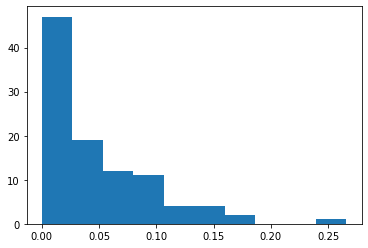

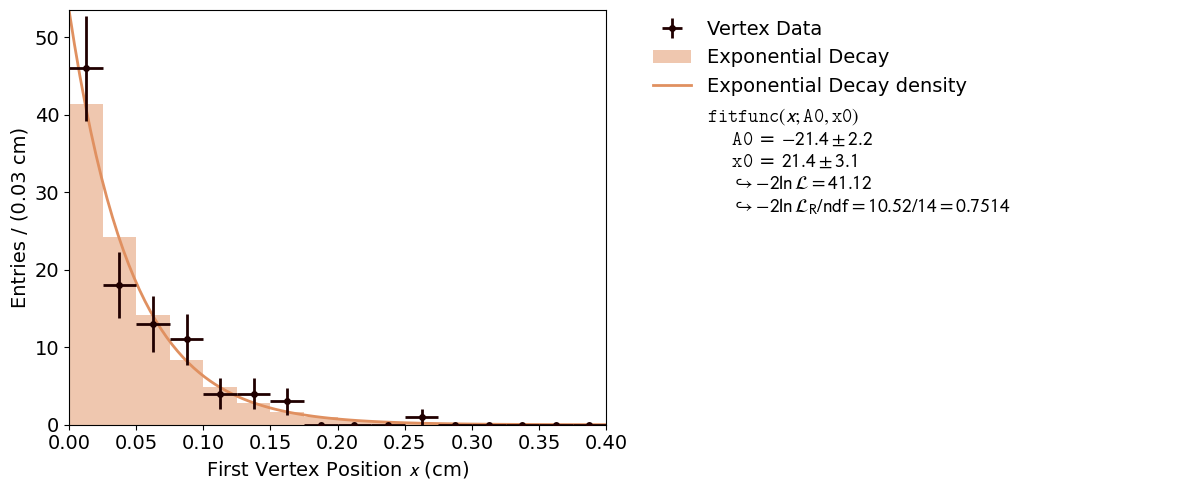

In [18]:
# Use of kafe2 for option b)
from kafe2 import XYContainer, Fit, Plot, HistContainer
from kafe2.fit.histogram import HistCostFunction_NegLogLikelihood

plt.hist(first_vertices)
plt.show()

# define fit function
def fitfunc(x, A0=-10., x0=10.):
    return x0 * np.exp(A0*x)

# prepare fit
bin_edges = [0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4]
nbins = len(bin_edges)-1
bin_range = (bin_edges[0], bin_edges[-1])
hdat = HistContainer(nbins, bin_range, bin_edges=bin_edges, fill_data=first_vertices)

hdat.label = "Vertex Data"
hdat.axis_labels= ['First Vertex Position $x$ (cm)', f'Entries / ({np.mean(np.diff(bin_edges)):.2f} cm)']

hfit = Fit(
    hdat, 
    fitfunc, 
    cost_function=HistCostFunction_NegLogLikelihood(data_point_distribution='poisson')
)

# add cosmetic options
# do not get hung up on this! Skip this, if you do not want to get (non existent) extra points for beauty
#hfit.assign_parameter_latex_names(Syntax: <parameter variable defined as in `fitfunf`>=<latex expression>) # input should be keywardarguments for all function arguments
#hfit.assign_model_function_latex_expression(<latex expression of formula>) # escape \ by \\ and expressions in {} need to be escaped as well, e.g. 1/2=\\frac{{1}}{{2}} or e^foo=e^{{foo}}
hfit.model_label = "Exponential Decay"

# execute fit
hfit.do_fit()

# show fit
plot = Plot(hfit)
foo = plot.plot()
plt.show()

<div class="alert alert-success">
<strong>Answer 2.3:</strong>

*Your answer...*
</div>

For the analysis of the shower depth and width, enlarge the dimensions of the lead block (about $(40\times 40\times 40)\,$cm) so that the full shower is contained in the lead block. 
Use energies of 3 GeV for the primary electrons for the analysis of the depth and width of the electromagnetic showers.

/tracking/storeTrajectory 2
Output file: g4_0000.prim
Destination directory (current dir if NULL): 
Maximal number of files in the destination directory: 1
Note:                                                
  * The maximal number is customizable as:           
       % setenv  G4DAWNFILE_MAX_FILE_NUM  number 
  * The destination directory is customizable as:
       % setenv  G4DAWNFILE_DEST_DIR  dir_name/  
     ** Do not forget "/" at the end of the    
        dir_name, e.g. "./tmp/".  

File  g4_0000.prim  is generated.
No viewer is invoked.


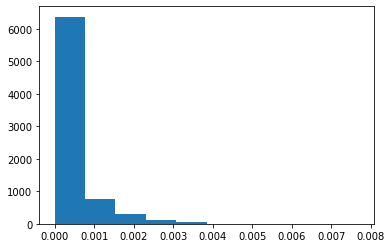

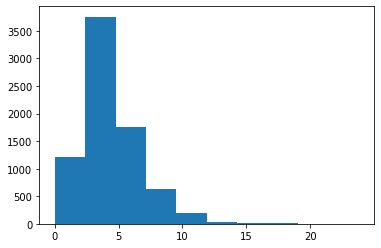

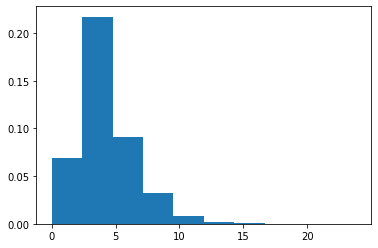

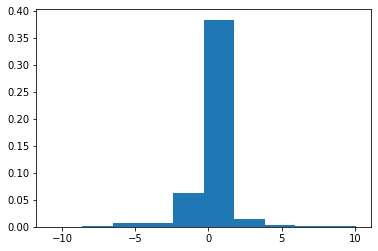

In [23]:
# Your code ...
# Set the geometry to example_geometry.
g4.set_geometry('pbbox(40,40)')

# Set the physics list used during the simulation.
g4.set_physics_list('EMPhysics')

# Initialize the Geant4 kernel.
g4.initialize()

# Set the primary particle and particle amount used in the simulation.
g4.set_particle(11) # 11 = electron
g4.set_numberOfParticles(1)

g4.set_energy(3)  # 3 GeV initial energy.

g4.start_run(numberOfEvents=1, visualize=0)

deposits = g4.get_step_energy_deposit()
x_pos = deposits[0]
yz_pos = deposits[1] + deposits[2]
e_dep = deposits[3]

#print(deposits[0])

plt.hist(e_dep)
plt.show()

plt.hist(x_pos)
plt.show()
plt.hist(x_pos, weights=e_dep, density=True)
plt.show()

plt.hist(yz_pos, weights=e_dep, density=True)
plt.show()

First, we will have a look at the distributions of the energy depositions in longitudinal ($x$-axis) and transverse ($y$-$z$-plane) directions for a single simulated event.
For this, fill two histograms with the positions of the energy depositions in each direction weighted by the energy deposited at this position.
The `get_step_energy_deposit()` method of the `ApplicationManager` class returns a list of four NumPy arrays representing the $x$, $y$, $z$ coordinates (in cm) and energy deposit (in GeV) at this point for each step of the particles through the detector.

**Hint:** Matplotlib's and NumPy's histogram modules both support costum weighting via a `weight` argument.

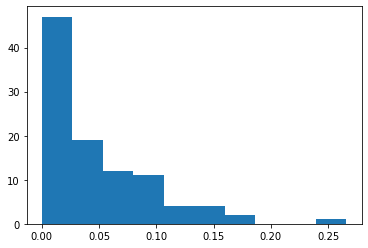

/tmp/ipykernel_1190/1479206196.py:10: RuntimeWarning: overflow encountered in exp
  return x0 * np.exp(A0*x)
/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:818: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu
/opt/conda/lib/python3.9/site-packages/kafe2/fit/histogram/model.py:120: RuntimeWarning: overflow encountered in multiply
  _height_edges[:-1] + 4.0 * _height_centers + _height_edges[1:])


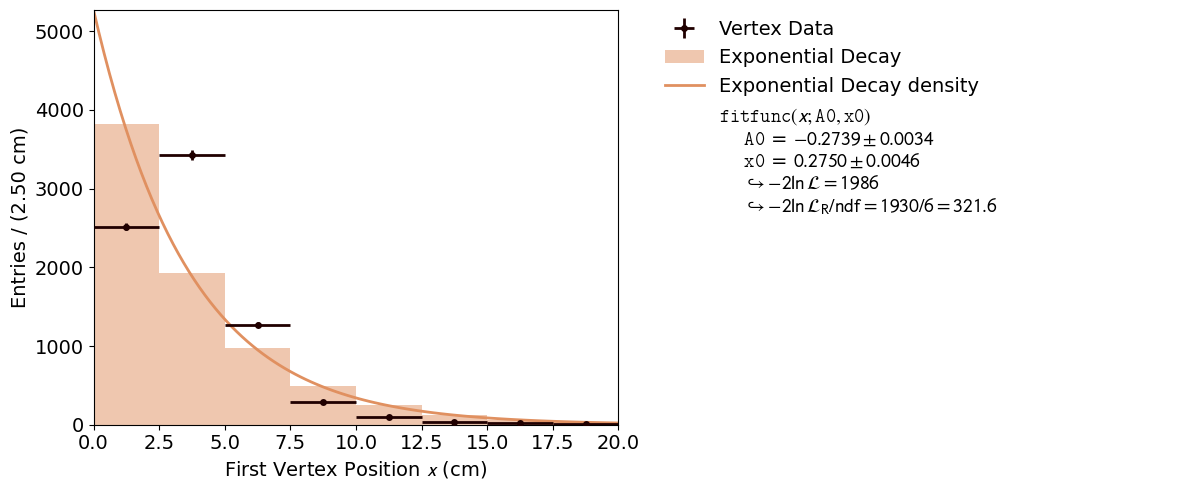

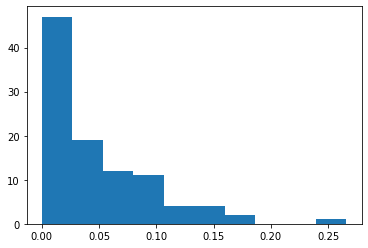

/tmp/ipykernel_1190/1479206196.py:50: RuntimeWarning: overflow encountered in exp
  return x0 * np.exp(A0*x)
/opt/conda/lib/python3.9/site-packages/scipy/stats/_discrete_distns.py:818: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu


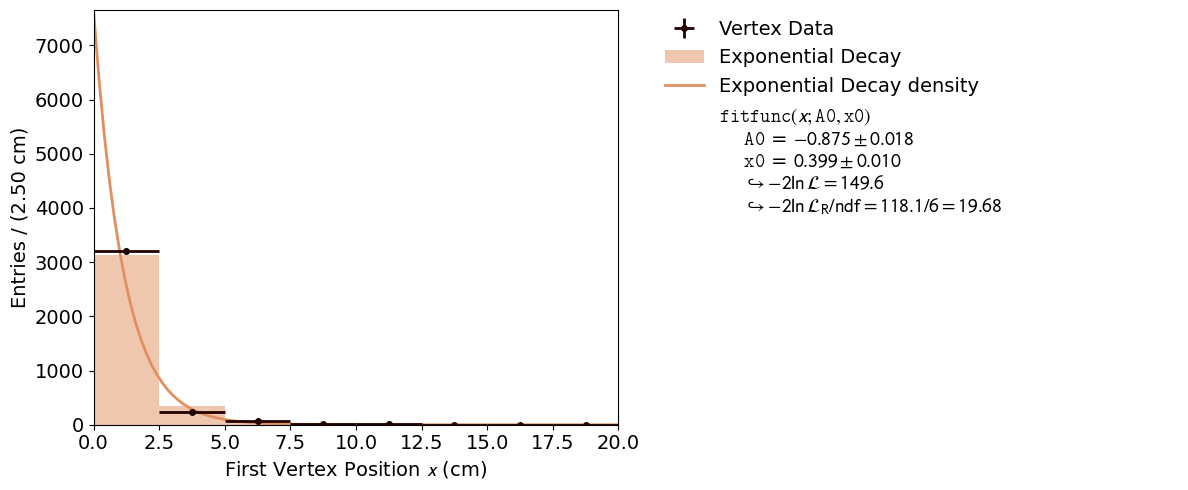

In [20]:
# Use of kafe2 for option b)
from kafe2 import XYContainer, Fit, Plot, HistContainer
from kafe2.fit.histogram import HistCostFunction_NegLogLikelihood

plt.hist(first_vertices)
plt.show()

# define fit function
def fitfunc(x, A0=-10., x0=10.):
    return x0 * np.exp(A0*x)

# prepare fit
bin_edges = [0., 2.5, 5., 7.5, 10., 12.5, 15., 17.5, 20.]
nbins = len(bin_edges)-1
bin_range = (bin_edges[0], bin_edges[-1])
hdat = HistContainer(nbins, bin_range, bin_edges=bin_edges, fill_data=x_pos)

hdat.label = "Vertex Data"
hdat.axis_labels= ['First Vertex Position $x$ (cm)', f'Entries / ({np.mean(np.diff(bin_edges)):.2f} cm)']

hfit = Fit(
    hdat, 
    fitfunc, 
    cost_function=HistCostFunction_NegLogLikelihood(data_point_distribution='poisson')
)

# add cosmetic options
# do not get hung up on this! Skip this, if you do not want to get (non existent) extra points for beauty
#hfit.assign_parameter_latex_names(Syntax: <parameter variable defined as in `fitfunf`>=<latex expression>) # input should be keywardarguments for all function arguments
#hfit.assign_model_function_latex_expression(<latex expression of formula>) # escape \ by \\ and expressions in {} need to be escaped as well, e.g. 1/2=\\frac{{1}}{{2}} or e^foo=e^{{foo}}
hfit.model_label = "Exponential Decay"

# execute fit
hfit.do_fit()

# show fit
plot = Plot(hfit)
foo = plot.plot()
plt.show()

# Use of kafe2 for option b)
from kafe2 import XYContainer, Fit, Plot, HistContainer
from kafe2.fit.histogram import HistCostFunction_NegLogLikelihood

plt.hist(first_vertices)
plt.show()

# define fit function
def fitfunc(x, A0=-10., x0=10.):
    return x0 * np.exp(A0*x)

# prepare fit
bin_edges = [0., 2.5, 5., 7.5, 10., 12.5, 15., 17.5, 20.]
nbins = len(bin_edges)-1
bin_range = (bin_edges[0], bin_edges[-1])
hdat = HistContainer(nbins, bin_range, bin_edges=bin_edges, fill_data=yz_pos)

hdat.label = "Vertex Data"
hdat.axis_labels= ['First Vertex Position $x$ (cm)', f'Entries / ({np.mean(np.diff(bin_edges)):.2f} cm)']

hfit = Fit(
    hdat, 
    fitfunc, 
    cost_function=HistCostFunction_NegLogLikelihood(data_point_distribution='poisson')
)

# add cosmetic options
# do not get hung up on this! Skip this, if you do not want to get (non existent) extra points for beauty
#hfit.assign_parameter_latex_names(Syntax: <parameter variable defined as in `fitfunf`>=<latex expression>) # input should be keywardarguments for all function arguments
#hfit.assign_model_function_latex_expression(<latex expression of formula>) # escape \ by \\ and expressions in {} need to be escaped as well, e.g. 1/2=\\frac{{1}}{{2}} or e^foo=e^{{foo}}
hfit.model_label = "Exponential Decay"

# execute fit
hfit.do_fit()

# show fit
plot = Plot(hfit)
foo = plot.plot()
plt.show()

As the last step, study the shower dimension parallel and perpendicular to the flight direction of the electron.
The dimensions of a shower can be defined as the 90 % quantile of the distributions of deposited energy.
To calculate the so-defined dimension, repeat the previous exercise and calculate at which energy-weighted position the 90 % quantile is reached.

Simulate 500 events and calculate the shower dimensions. Histogram the results and calculate the mean of each distribution.

<div class="alert alert-info">
<strong>Question 2.4:</strong> 
How many $X_{0}$ are sufficient to contain at least 90 % of the shower longitudinally?
</div>  

<div class="alert alert-success">
<strong>Answer 2.4:</strong>

*Your answer...*
</div>

<div class="alert alert-info">
<strong>Question 2.5:</strong> 
How many radiation lengths are typically used for electromagnetic calorimeters in detectors like the CMS detector?
</div>  

<div class="alert alert-success">
<strong>Answer 2.5:</strong>

*Your answer...*
</div>

<div class="alert alert-info">
<strong>Bonus question:</strong> 
What is the transverse shower shape? How many $X_0$ are needed to contain the shower?
</div>  

<div class="alert alert-success">
<strong>Answer Bonus:</strong>
    
*Your answer...*
</div>

---
# Calorimeter <a id="Intro"></a>
---
In the lectures two specialised calorimeter concepts with the common task of measuring the energy of incoming particles were introduced.
The distinction between these two types is often made because of the respective challenges they face:
- Electromagnetic calorimeters are primarily optimised to measure as precisely as possible the energy of photons and electrons.

In the previous exercises, you were already made familiar with the basic concepts of this type of shower.
The other type of calorimeters, namely hadron calorimeters, specials on dealing with hadronic showers.
The key differences for hadronic showers are:

- The hadronic interaction length is much larger than the radiation length of photons and electrons.
- Hadronic showers consist to about a third of neutral pions that decay into two photons.
- Lastly, hadronic showers contain a large fraction (20-40%) of "invisible" particles which reduces the possible energy resolution in comparison to electromagnetic calorimeters. 

<div>
<img src="HadronicShower.png" width="800"/>
</div>

[Source](https://www.physi.uni-heidelberg.de/~sma/teaching/ParticleDetectors2/sma_HadronicCalorimeters.pdf)


Another design choice for calorimeters is (are) the used material(s). A first-order distinction can be made for the homogenous and sampling calorimeter:
- **Sampling calorimeter** <br>
    Sampling calorimeters have a layered structure with alternating layers of absorber (passive) and detector (active) material.
    On the one hand, the design and material choice are flexible and optimisable to a specific task or financial budget.
    On the other hand, some of the energy is deposited in the absorber which limits the energy resolution.
- **Homogenous calorimeter** <br>
    Here, one material is used simultaneously as an absorber and active material.
    Consequently, all the energy is deposited in the detector which allows for an optimal energy resolution.
    Also, the choice of the material can be specialised to the task, e.g. CsI has a very low light yield but allows for fast readout; CsI(Tl) has high light yield but slow readout. 
    However, the materials capable of this task (mostly scintillator crystals) are custom made which makes them often very expensive and very heavy.
    
The following exercises will focus on a sampling calorimeter structure with lead absorbers and liquid argon as active material.

A key aspect of calorimeters is the readout of the detector which determines the measured energy of the particle.
As discussed in the lecture the total number of particles in an electromagnetic shower is proportional to the initial energy of the particle.
One very common use case in high-energy particle experiments is the use of scintillation materials.
In this case, the electromagnetic shower leads to the production of photons in the visible spectrum which can be measured by photo multipliers, photo diodes, etc.
For example, the voltage measured at a silicon photomultiplier is proportional to the number of incoming photons which in turn is proportional to the initial energy.
The following exercises will discuss a closely related measurement principle: The count of charged particles in the active material.

---
# Exercise 3: Calorimeter calibration <a id="Exercise3"></a>
---

This exercise presents a very simplified version of the calibration of the photon energy deposition in a calorimeter. 
The goal is to determine the relation between the number of charged shower particles (in reality this would be a current) in the detector and the corresponding initial energy.
The setup is inspired by the [sampling electromagnetic calorimeter (ECAL) of ATLAS](https://atlas.cern/Discover/Detector/Calorimeter).
Here, incoming particles can shower in the lead absorbers.
The shower particles then ionize the liquid argon, ions drift to electrodes and the resulting number of charged particles (current) is measured.

To set up the simulation for this exercise follow the initialization instructions from the previous exercises.
In this and the following exercises, we will use a different physics list than in the previous exercises. 
We will use the physics list `MyQGSP_BERT` which includes hadronic interactions as well.

The desired sampling calorimeter can be built by the `samplingcalo(lenAbsorber, lenActive, numLayers)` geometry.
This method produces `numLayers` layers of $(10\times 10\times\text{lenAbsrober/lenActive})\,$cm alternating absorber/active material. <br>
For example,
```python
  g4.set_geometry('samplingcalo(2.,1.,15)')
```
will create a calorimeter with lead absorbers of thickness 2 cm and scintillator tiles of thickness 1 cm, and a total of 15 absorber layers.

Initialize the simulation:
- build the calorimeter from the example,
- set the correct physics list and
- initialize.

In [24]:
import geant4_simulation as g4sim
import numpy as np
import matplotlib.pyplot as plt
from kafe2 import XYContainer, Fit, Plot

# Set the geometry to example_geometry.
g4.set_geometry('samplingcalo(2.,1.,15)')

# Set the physics list used during the simulation.
g4.set_physics_list('MyQGSP_BERT')

# Initialize the Geant4 kernel.
g4.initialize()

# Set the primary particle and particle amount used in the simulation.
g4.set_particle(22) # 22 = photon
g4.set_numberOfParticles(1)

g4.set_energy(1)  # 1 GeV initial energy.



/tracking/storeTrajectory 2
Output file: g4_0000.prim
Destination directory (current dir if NULL): 
Maximal number of files in the destination directory: 1
Note:                                                
  * The maximal number is customizable as:           
       % setenv  G4DAWNFILE_MAX_FILE_NUM  number 
  * The destination directory is customizable as:
       % setenv  G4DAWNFILE_DEST_DIR  dir_name/  
     ** Do not forget "/" at the end of the    
        dir_name, e.g. "./tmp/".  

File  g4_0000.prim  is generated.
No viewer is invoked.


In this exercise, calibrate the given calorimeter for photons, i.e. determine the constant that translates the number $N_{c}$ of charged particles passing the scintillator into the energy $E_{\text{in}}$ of the initial particle.

To compute $N_{c}$, simulate for 15 different energies in the interval of $[1, 15]\,$GeV the interaction of 10 photons with the given calorimeter.
For each simulated photon, read the number of charged particles traversing the scintillator layers. 
The number can be obtained using the `calo_readout()` method from the `ApplicationManager` class. 
Be aware, this method only works for one event, therefore, you need to loop over the desired number of photon interaction simulations.
Compute the mean and its uncertainty (standard deviation divided by the square root of the number of samples) for each energy and store the result.
Finally, fit the mean number of charged tracks per event and the simulated energy with an appropriate model.

**Hint**: A smaller sample size while debugging the code can be useful here. <br>
**Hint**: For a fit with `kafe2` you can use the `XYContainer` and `Fit` modules.

In [33]:
nr_particles = 10
cr_means_pe = []
cr_unc_pe = []

energies = np.linspace(1, 15, 15)
    
for i in range(0, 15):
    
    cr_pp = []
        
    g4.set_energy(energies[i])
        
    for j in range(nr_particles):
            g4.start_run(numberOfEvents=1, visualize=0)
            
            cr_pp.append(g4.calo_readout())
    
    cr_means_pe.append(np.mean(cr_pp))
    cr_unc_pe.append(np.std(cr_pp)/np.sqrt(10))

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
[42.2, 94.8, 138.2, 181.4, 239.5, 289.8, 327.8, 381.3, 423.7, 464.3, 494.9, 557.0, 615.5, 667.9, 707.6]
[2.2126906697502924, 2.2126906697502924, 5.397777320342142, 8.533697908878658, 7.168333139579939, 12.158782833820169, 8.443695873253608, 9.001166591059183, 11.405305782836335, 10.299563097529914, 8.986044736145042, 10.355674772799693, 11.528443086557697, 11.890710660006828, 11.343897037614543]


<function matplotlib.pyplot.show(close=None, block=None)>

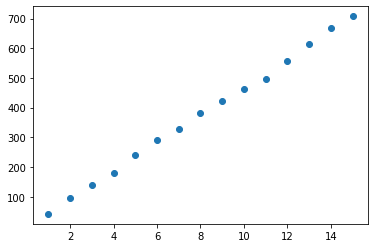

In [34]:
print(energies)
print(cr_means_pe)
print(cr_unc_pe)

plt.plot(energies, cr_means_pe, 'o')
plt.show

########
# Data #
########

    X Data
    1.0   
    2.0   
    3.0   
    4.0   
    5.0   
    6.0   
    7.0   
    8.0   
    9.0   
    10.0  
    11.0  
    12.0  
    13.0  
    14.0  
    15.0  

    Y Data  Y Data Error  Y Data Correlation Matrix                     
    ======  ============  ==============================================
    42.2    2.213         [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
    94.8    2.213         [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
    138.2   5.398         [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
    181.4   8.534         [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
    239.5   7.168         [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
    289.8   12.16         [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
    327.8   8.444         [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
    381.3   9.001         [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
    423.7   11.41         [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.

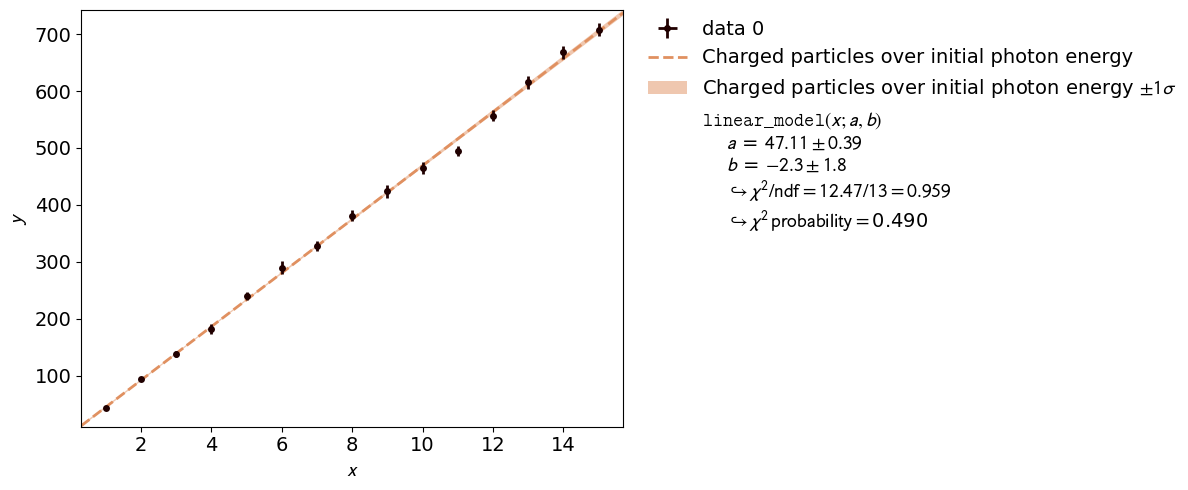

In [35]:
# Use of kafe2 for option b)
from kafe2 import XYContainer, Fit, Plot, HistContainer
from kafe2.fit.histogram import HistCostFunction_NegLogLikelihood


def linear_model(x, a=10, b=10):
    # Our first model is a simple linear function
    return a * x + b

xy_data = XYContainer(x_data=energies,
                      y_data=cr_means_pe)

xy_data.add_error(axis='y', err_val=cr_unc_pe)

# Create Fit object
lin_fit = Fit(data=xy_data, model_function=linear_model)

# add cosmetic options
# do not get hung up on this! Skip this, if you do not want to get (non existent) extra points for beauty
#hfit.assign_parameter_latex_names(Syntax: <parameter variable defined as in `fitfunf`>=<latex expression>) # input should be keywardarguments for all function arguments
#hfit.assign_model_function_latex_expression(<latex expression of formula>) # escape \ by \\ and expressions in {} need to be escaped as well, e.g. 1/2=\\frac{{1}}{{2}} or e^foo=e^{{foo}}
lin_fit.model_label = "Charged particles over initial photon energy"

# execute fit
lin_fit.do_fit()

lin_fit.report()

# show fit
plot = Plot(lin_fit)
foo = plot.plot()
plt.show()